<a href="https://colab.research.google.com/github/IbrahimTGhanem/Datathon4/blob/main/Dathathon_04_Group_02_edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Section 1: Introduction**

"The accurate prediction of mortality in the first 24 hours following admission to an Intensive Care Unit (ICU) is of paramount importance in clinical medicine. Early and precise mortality risk assessment allows for effective resource allocation, ensuring that critical medical equipment and skilled personnel are available for the patients who need them the most. Additionally, it aids in strategic planning, allowing medical teams to prioritize interventions, tailor treatment plans, and make informed decisions about the potential benefits of aggressive versus palliative care strategies. Furthermore, early mortality predictions provide invaluable information to families, facilitating difficult conversations and helping loved ones set realistic expectations, prepare for potential outcomes, and make time-sensitive decisions about end-of-life care. In an environment where every moment counts, leveraging data from the first 24 hours of ICU admission for mortality prediction not only optimizes clinical interventions but also provides compassionate guidance to families during their most challenging times. Recognizing this, this datathon aims to explore the power of Machine Learning models to predict mortality using real-world data from that critical first day in the ICU, all with the goal of enhancing patient care and supporting families in their tough moments.

This dataset is provided in collaboration with MIT’s GOSSIS community initiative and has received privacy certification from the Harvard Privacy Lab. It includes records from over 91,000 intensive care unit (ICU) visits at various hospitals, covering an entire year. What makes this dataset truly unique is its global scope, as it is part of a collaborative effort connecting healthcare institutions in Argentina, Australia, New Zealand, Sri Lanka, Brazil, and over 200 hospitals in the United States".

**1.1: Importing Libraries and exploring data**

In [ ]:
pip install category-encoders

In [ ]:
# !pip install category_encoders

import pandas as pd
import numpy as np
import warnings
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
# from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import plotly.express as px
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


warnings.filterwarnings('ignore')

In [ ]:
#additional libraries on the go, as analysis require
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.metrics import make_scorer
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

In [ ]:
from google.colab import files

# Specify the path to the file on local machine
uploaded = files.upload()

Saving datathon4.csv to datathon4 (2).csv


In [ ]:
data = pd.read_csv('datathon4.csv')
data.head()

encounter_id  patient_id  hospital_id  hospital_death   age    bmi  \
0         66154       25312          118               0  68.0  22.73   
1        114252       59342           81               0  77.0  27.42   
2        119783       50777          118               0  25.0  31.95   
3         79267       46918          118               0  81.0  22.64   
4         92056       34377           33               0  19.0    NaN   

   elective_surgery  ethnicity gender  height  ... aids cirrhosis  \
0                 0  Caucasian      M   180.3  ...  0.0       0.0   
1                 0  Caucasian      F   160.0  ...  0.0       0.0   
2                 0  Caucasian      F   172.7  ...  0.0       0.0   
3                 1  Caucasian      F   165.1  ...  0.0       0.0   
4                 0  Caucasian      M   188.0  ...  0.0       0.0   

   diabetes_mellitus hepatic_failure immunosuppression  leukemia  lymphoma  \
0                1.0             0.0               0.0       0.0       0.0   
1                1.0             0.0               0.0       0.0       0.0   
2                0.0             0.0               0.0       0.0       0.0   
3                0.0             0.0               0.0       0.0       0.0   
4                0.0             0.0               0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  
0                          0.0                Sepsis       Cardiovascular  
1                          0.0           Respiratory          Respiratory  
2                          0.0             Metabolic            Metabolic  
3                          0.0        Cardiovascular       Cardiovascular  
4                          0.0                Trauma               Trauma  

[5 rows x 186 columns]

**1.2: Process of omitting columns (ensuring high data quality)**

It is important examine variables and identify/drop irrelevant columns (i.e. identifiers/administrative data) and variables with a single value or with significant level of missing values. The threshold for that will be set at 20%, based on findings from literature:
Peng CYJ, Harwell M, Liou SM, Ehman LH. Advances in missing data methods and implications for educational research. In: Sawilowsky SS, editor. Real data analysis. Charlotte, North Carolina: Information Age Pub; 2006. pp. 31–78.

In [ ]:
#Dropping identifiers
identifiers_to_drop = ['encounter_id', 'hospital_id', 'patient_id', 'icu_id']
data = data.drop(columns=identifiers_to_drop)

In [ ]:
#dropping administrative columns
admins_to_drop = ['hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']
data = data.drop(columns=admins_to_drop)

single-value columns will not add value to any prediction models. In fact, it might represent noise in models

In [ ]:
# Creating an empty list to store the names of columns with a single value
single_value_columns = []

# Iterating through the columns
for column in data.columns:
    if data[column].nunique() == 1:
        single_value_columns.append(column)

# Printing the list of columns with a single value
print("Columns with a single value for all observations:")
print(single_value_columns)

Columns with a single value for all observations:
['readmission_status']


In [ ]:
#dropping single values columns as they may impact the analysis
data = data.drop(columns=single_value_columns)

Also, after examining variables closely it appears that over the column of pre_icu_los_days has around 750 of negative values. This variable represents the length of stay of a patient between hospital admission and unit admission. Yet, having negative values indicates a data quality aspect. Thus, this variable will be removed from analysis

In [ ]:
low_quality_variable = ['pre_icu_los_days']
data = data.drop(columns=low_quality_variable)

In [ ]:
#Describing data after omitting variables
description = data.describe()
description

hospital_death           age           bmi  elective_surgery  \
count    91713.000000  87485.000000  88284.000000      91713.000000   
mean         0.086302     62.309516     29.185818          0.183736   
std          0.280811     16.775119      8.275142          0.387271   
min          0.000000     16.000000     14.844926          0.000000   
25%          0.000000     52.000000     23.641975          0.000000   
50%          0.000000     65.000000     27.654655          0.000000   
75%          0.000000     75.000000     32.930206          0.000000   
max          1.000000     89.000000     67.814990          1.000000   

             height        weight  albumin_apache  apache_2_diagnosis  \
count  90379.000000  88993.000000    37334.000000        90051.000000   
mean     169.641588     84.028340        2.902968          185.401739   
std       10.795378     25.011497        0.681863           86.050882   
min      137.200000     38.600000        1.200000          101.000000   
25%      162.500000     66.800000        2.400000          113.000000   
50%      170.100000     80.300000        2.900000          122.000000   
75%      177.800000     97.100000        3.400000          301.000000   
max      195.590000    186.000000        4.600000          308.000000   

       apache_3j_diagnosis  apache_post_operative  ...  \
count         90612.000000           91713.000000  ...   
mean            558.216377               0.201106  ...   
std             463.266985               0.400829  ...   
min               0.010000               0.000000  ...   
25%             203.010000               0.000000  ...   
50%             409.020000               0.000000  ...   
75%             703.030000               0.000000  ...   
max            2201.050000               1.000000  ...   

       apache_4a_hospital_death_prob  apache_4a_icu_death_prob          aids  \
count                   83766.000000              83766.000000  90998.000000   
mean                        0.086787                  0.043955      0.000857   
std                         0.247569                  0.217341      0.029265   
min                        -1.000000                 -1.000000      0.000000   
25%                         0.020000                  0.010000      0.000000   
50%                         0.050000                  0.020000      0.000000   
75%                         0.130000                  0.060000      0.000000   
max                         0.990000                  0.970000      1.000000   

          cirrhosis  diabetes_mellitus  hepatic_failure  immunosuppression  \
count  90998.000000       90998.000000     90998.000000       90998.000000   
mean       0.015693           0.225192         0.012989           0.026165   
std        0.124284           0.417711         0.113229           0.159628   
min        0.000000           0.000000         0.000000           0.000000   
25%        0.000000           0.000000         0.000000           0.000000   
50%        0.000000           0.000000         0.000000           0.000000   
75%        0.000000           0.000000         0.000000           0.000000   
max        1.000000           1.000000         1.000000           1.000000   

           leukemia      lymphoma  solid_tumor_with_metastasis  
count  90998.000000  90998.000000                 90998.000000  
mean       0.007066      0.004132                     0.020638  
std        0.083763      0.064148                     0.142169  
min        0.000000      0.000000                     0.000000  
25%        0.000000      0.000000                     0.000000  
50%        0.000000      0.000000                     0.000000  
75%        0.000000      0.000000                     0.000000  
max        1.000000      1.000000                     1.000000  

[8 rows x 172 columns]

**Section 2: Data Engineering Process**

**2.1: Visualizing the distribution of missing values and omitting variables with missing values that is above 20%**

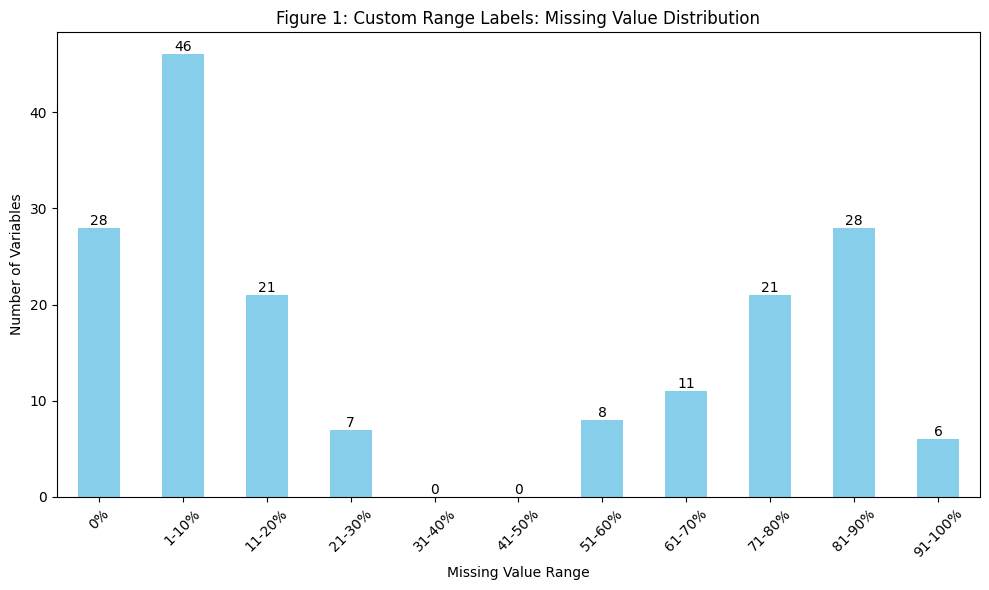

In [ ]:
# Calculating the percentage of missing values in each column
missing_percentage = (data.isnull().mean() * 100)

# Defining custom range for bars
custom_labels = ['0%', '1-10%', '11-20%', '21-30%', '31-40%', '41-50%', '51-60%', '61-70%', '71-80%', '81-90%', '91-100%']

# Defining the range thresholds for bars
ranges = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Creating a dictionary to count variables in each range
range_counts = {custom_labels[i]: ((missing_percentage >= start) & (missing_percentage < end)).sum() for i, (start, end) in enumerate(zip(ranges, ranges[1:]))}

# Converting the dictionary to a DataFrame for plotting
range_counts_df = pd.DataFrame.from_dict(range_counts, orient='index', columns=['Count'])

# Plotting the bar chart
plt.figure(figsize=(10, 6))
ax = range_counts_df.plot(kind='bar', ax=plt.gca(), color='skyblue', legend=False)
plt.xlabel("Missing Value Range")
plt.ylabel("Number of Variables")
plt.title("Figure 1: Custom Range Labels: Missing Value Distribution")
plt.xticks(rotation=45)

# Adding count labels to the bars
for i, v in enumerate(range_counts_df['Count']):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Setting the threshold for the percentage of missing values
missing_threshold = 20  # 20% or more missing values

# Filtering columns with missing values exceeding the threshold
columns_with_high_missing = missing_percentage[missing_percentage > missing_threshold]

# Listing the columns with more than 20% missing values
print("Columns with more than 20% missing values:")
print(columns_with_high_missing.index.tolist())

Columns with more than 20% missing values:
['albumin_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'hematocrit_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'sodium_apache', 'urineoutput_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobi

In [ ]:
count_of_high_missing_columns = len(columns_with_high_missing)
print("Count of columns with more than 20% missing values:", count_of_high_missing_columns)

Count of columns with more than 20% missing values: 81


In [ ]:
#dropping variables with significant level of missing values
High_missing_values_to_drop = ['albumin_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'hematocrit_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'sodium_apache', 'urineoutput_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min', 'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max', 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min']
data = data.drop(columns=High_missing_values_to_drop)

In [ ]:
# Checking for missing values
missing_value_counts = data.isnull().sum()
missing_value_counts

hospital_death                    0
age                            4228
bmi                            3429
elective_surgery                  0
ethnicity                      1395
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 95, dtype: int64

In [ ]:
# Printing the dimension of the dataset
print(data.shape)

(91713, 95)


In [ ]:
variables_list = data.columns.tolist()

# Printing the list of variables
print("List of Variables:")
for variable in variables_list:
    print(variable)

List of Variables:
hospital_death
age
bmi
elective_surgery
ethnicity
gender
height
weight
apache_2_diagnosis
apache_3j_diagnosis
apache_post_operative
arf_apache
gcs_eyes_apache
gcs_motor_apache
gcs_unable_apache
gcs_verbal_apache
glucose_apache
heart_rate_apache
intubated_apache
map_apache
resprate_apache
temp_apache
ventilated_apache
d1_diasbp_max
d1_diasbp_min
d1_diasbp_noninvasive_max
d1_diasbp_noninvasive_min
d1_heartrate_max
d1_heartrate_min
d1_mbp_max
d1_mbp_min
d1_mbp_noninvasive_max
d1_mbp_noninvasive_min
d1_resprate_max
d1_resprate_min
d1_spo2_max
d1_spo2_min
d1_sysbp_max
d1_sysbp_min
d1_sysbp_noninvasive_max
d1_sysbp_noninvasive_min
d1_temp_max
d1_temp_min
h1_diasbp_max
h1_diasbp_min
h1_diasbp_noninvasive_max
h1_diasbp_noninvasive_min
h1_heartrate_max
h1_heartrate_min
h1_mbp_max
h1_mbp_min
h1_mbp_noninvasive_max
h1_mbp_noninvasive_min
h1_resprate_max
h1_resprate_min
h1_spo2_max
h1_spo2_min
h1_sysbp_max
h1_sysbp_min
h1_sysbp_noninvasive_max
h1_sysbp_noninvasive_min
d1_bun_max

**2.2 Examining the association between hospital death event and missing values in categorical, integer, and binary variables.**

Types of variables were obtained from the data dictionary sheet

In [ ]:
# Listing of categorical variables
categorical_variables = ['apache_3j_bodysystem', 'apache_2_bodysystem', 'ethnicity', 'gender']

# Binary label variable
binary_label = 'hospital_death'

# Creating a function to apply a chi-squared test and check for association
def chi_squared_test(data, categorical_variable, binary_label):
    contingency_table = pd.crosstab(data[categorical_variable].isnull(), data[binary_label])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# Applying a chi-squared tests for each categorical variable
for variable in categorical_variables:
    p_value = chi_squared_test(data, variable, binary_label)
    print(f"Chi-squared test for {variable}:")
    print(f"  - P-value: {p_value}")
    if p_value < 0.05:
        print("  - There is a significant association between missing values and hospital death.")
    else:
        print("  - There is no significant association between missing values and hospital death.")
    print("\n")

Chi-squared test for apache_3j_bodysystem:
  - P-value: 0.5410461111346306
  - There is no significant association between missing values and hospital death.


Chi-squared test for apache_2_bodysystem:
  - P-value: 0.5410461111346306
  - There is no significant association between missing values and hospital death.


Chi-squared test for ethnicity:
  - P-value: 0.15250983852914854
  - There is no significant association between missing values and hospital death.


Chi-squared test for gender:
  - P-value: 0.0001414835016997219
  - There is a significant association between missing values and hospital death.




With regard to gender, the signficance here can be ignored as missing observations are only 25

In [ ]:
# Listing of binary variables
binary_variables = [
    "elective_surgery",
    "apache_post_operative",
    "arf_apache",
    "gcs_unable_apache",
    "intubated_apache",
    "ventilated_apache",
    "aids",
    "cirrhosis",
    "diabetes_mellitus",
    "hepatic_failure",
    "immunosuppression",
    "leukemia",
    "lymphoma",
    "solid_tumor_with_metastasis"
]

# Binary label variable
binary_label = 'hospital_death'

# Creating a function to perform a chi-squared test and check for association
def chi_squared_test(data, binary_variable, binary_label):
    contingency_table = pd.crosstab(data[binary_variable] == 'NA', data[binary_label])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# Applying chi-squared tests for each binary variable
for variable in binary_variables:
    p_value = chi_squared_test(data, variable, binary_label)
    print(f"Chi-squared test for {variable}:")
    print(f"  - P-value: {p_value}")
    if p_value < 0.05:
        print("  - There is a significant association between missing values and hospital death.")
    else:
        print("  - There is no significant association between missing values and hospital death.")
    print("\n")

Chi-squared test for elective_surgery:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for apache_post_operative:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for arf_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for gcs_unable_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for intubated_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for ventilated_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for aids:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for cir

In [ ]:
ordinal_variables = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']

# Creating a function to apply a chi-squared test and check for association
def chi_squared_test(data, integer_variable, binary_label):
    contingency_table = pd.crosstab(data[integer_variable].astype(str) == 'NA', data[binary_label])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# Applying chi-squared tests for each integer variable
for variable in ordinal_variables:
    p_value = chi_squared_test(data, variable, binary_label)
    print(f"Chi-squared test for {variable}:")
    print(f"  - P-value: {p_value}")
    if p_value < 0.05:
        print("  - There is a significant association between missing values and hospital death.")
    else:
        print("  - There is no significant association between missing values and hospital death.")
    print("\n")

Chi-squared test for gcs_eyes_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for gcs_motor_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for gcs_verbal_apache:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.




In [ ]:
integer_variables = ['apache_2_diagnosis', 'apache_3j_diagnosis',]

# Creating a function to perform a chi-squared test and check for association
def chi_squared_test(data, integer_variable, binary_label):
    contingency_table = pd.crosstab(data[integer_variable].astype(str) == 'NA', data[binary_label])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# Performing chi-squared tests for each integer variable
for variable in integer_variables:
    p_value = chi_squared_test(data, variable, binary_label)
    print(f"Chi-squared test for {variable}:")
    print(f"  - P-value: {p_value}")
    if p_value < 0.05:
        print("  - There is a significant association between missing values and hospital death.")
    else:
        print("  - There is no significant association between missing values and hospital death.")
    print("\n")

Chi-squared test for apache_2_diagnosis:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.


Chi-squared test for apache_3j_diagnosis:
  - P-value: 1.0
  - There is no significant association between missing values and hospital death.




In [ ]:
# Listing of numeric variables
numeric_variables = [
    "age",
    "bmi",
    "height",
    "weight",
    "glucose_apache",
    "heart_rate_apache",
    "map_apache",
    "resprate_apache",
    "temp_apache",
    "d1_diasbp_max",
    "d1_diasbp_min",
    "d1_diasbp_noninvasive_max",
    "d1_diasbp_noninvasive_min",
    "d1_heartrate_max",
    "d1_heartrate_min",
    "d1_mbp_max",
    "d1_mbp_min",
    "d1_mbp_noninvasive_max",
    "d1_mbp_noninvasive_min",
    "d1_resprate_max",
    "d1_resprate_min",
    "d1_spo2_max",
    "d1_spo2_min",
    "d1_sysbp_max",
    "d1_sysbp_min",
    "d1_sysbp_noninvasive_max",
    "d1_sysbp_noninvasive_min",
    "d1_temp_max",
    "d1_temp_min",
    "h1_diasbp_max",
    "h1_diasbp_min",
    "h1_diasbp_noninvasive_max",
    "h1_diasbp_noninvasive_min",
    "h1_heartrate_max",
    "h1_heartrate_min",
    "h1_mbp_max",
    "h1_mbp_min",
    "h1_mbp_noninvasive_max",
    "h1_mbp_noninvasive_min",
    "h1_resprate_max",
    "h1_resprate_min",
    "h1_spo2_max",
    "h1_spo2_min",
    "h1_sysbp_max",
    "h1_sysbp_min",
    "h1_sysbp_noninvasive_max",
    "h1_sysbp_noninvasive_min",
    "d1_bun_max",
    "d1_bun_min",
    "d1_calcium_max",
    "d1_calcium_min",
    "d1_creatinine_max",
    "d1_creatinine_min",
    "d1_glucose_max",
    "d1_glucose_min",
    "d1_hco3_max",
    "d1_hco3_min",
    "d1_hemaglobin_max",
    "d1_hemaglobin_min",
    "d1_hematocrit_max",
    "d1_hematocrit_min",
    "d1_platelets_max",
    "d1_platelets_min",
    "d1_potassium_max",
    "d1_potassium_min",
    "d1_sodium_max",
    "d1_sodium_min",
    "d1_wbc_max",
    "d1_wbc_min",
    "apache_4a_hospital_death_prob",
    "apache_4a_icu_death_prob"
]

Based on the application of the previous statistical test, there is no significant association between missing observations and the dependent variables. Thus, it is evident that that these missing values may be missing completely at random (MCAR) or at least missing at random (MAR). Thus, it is possible to apply imputation strategies.

**2.3: checking potential class imbalance**

In [ ]:
data['Hospital Death'] = np.where(data['hospital_death'] == 1, 'Passed Away', 'Did Not Pass Away')

In [ ]:
counts = data['Hospital Death'].value_counts()

# Define color sequence
colors = ['#1c3a73', '#7cb1c2']

fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # size of the hole, 0.5 means 50%
    title='Distribution of Classes in "Hospital Death"',
    color_discrete_sequence=colors  # apply colors here
)

# layout for better appearance
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),  # Adjust top margin to make room for title
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='Hospital Death'
    ),
    title=dict(
        text='Figure 2: Distribution of Classes in "Hospital Death"',
        x=0.45,  # Centering the title
        xanchor='center',
        y=0.95,  # Adjusting y position to place title above chart
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

fig.show()

While there are no missing values in the label class, there is a clear class imbalance in the label/target variable where only 8.6% of the observations belong to the category of 'Passed away'. This issue entails the need for either upsampling or downsampling, which will be tackled before running classification models.

**2.4 Vizualizing variables, and understanding outliers**

In [ ]:
data = data.replace('NA', np.nan)
data[categorical_variables] = data[categorical_variables].replace('', np.nan)

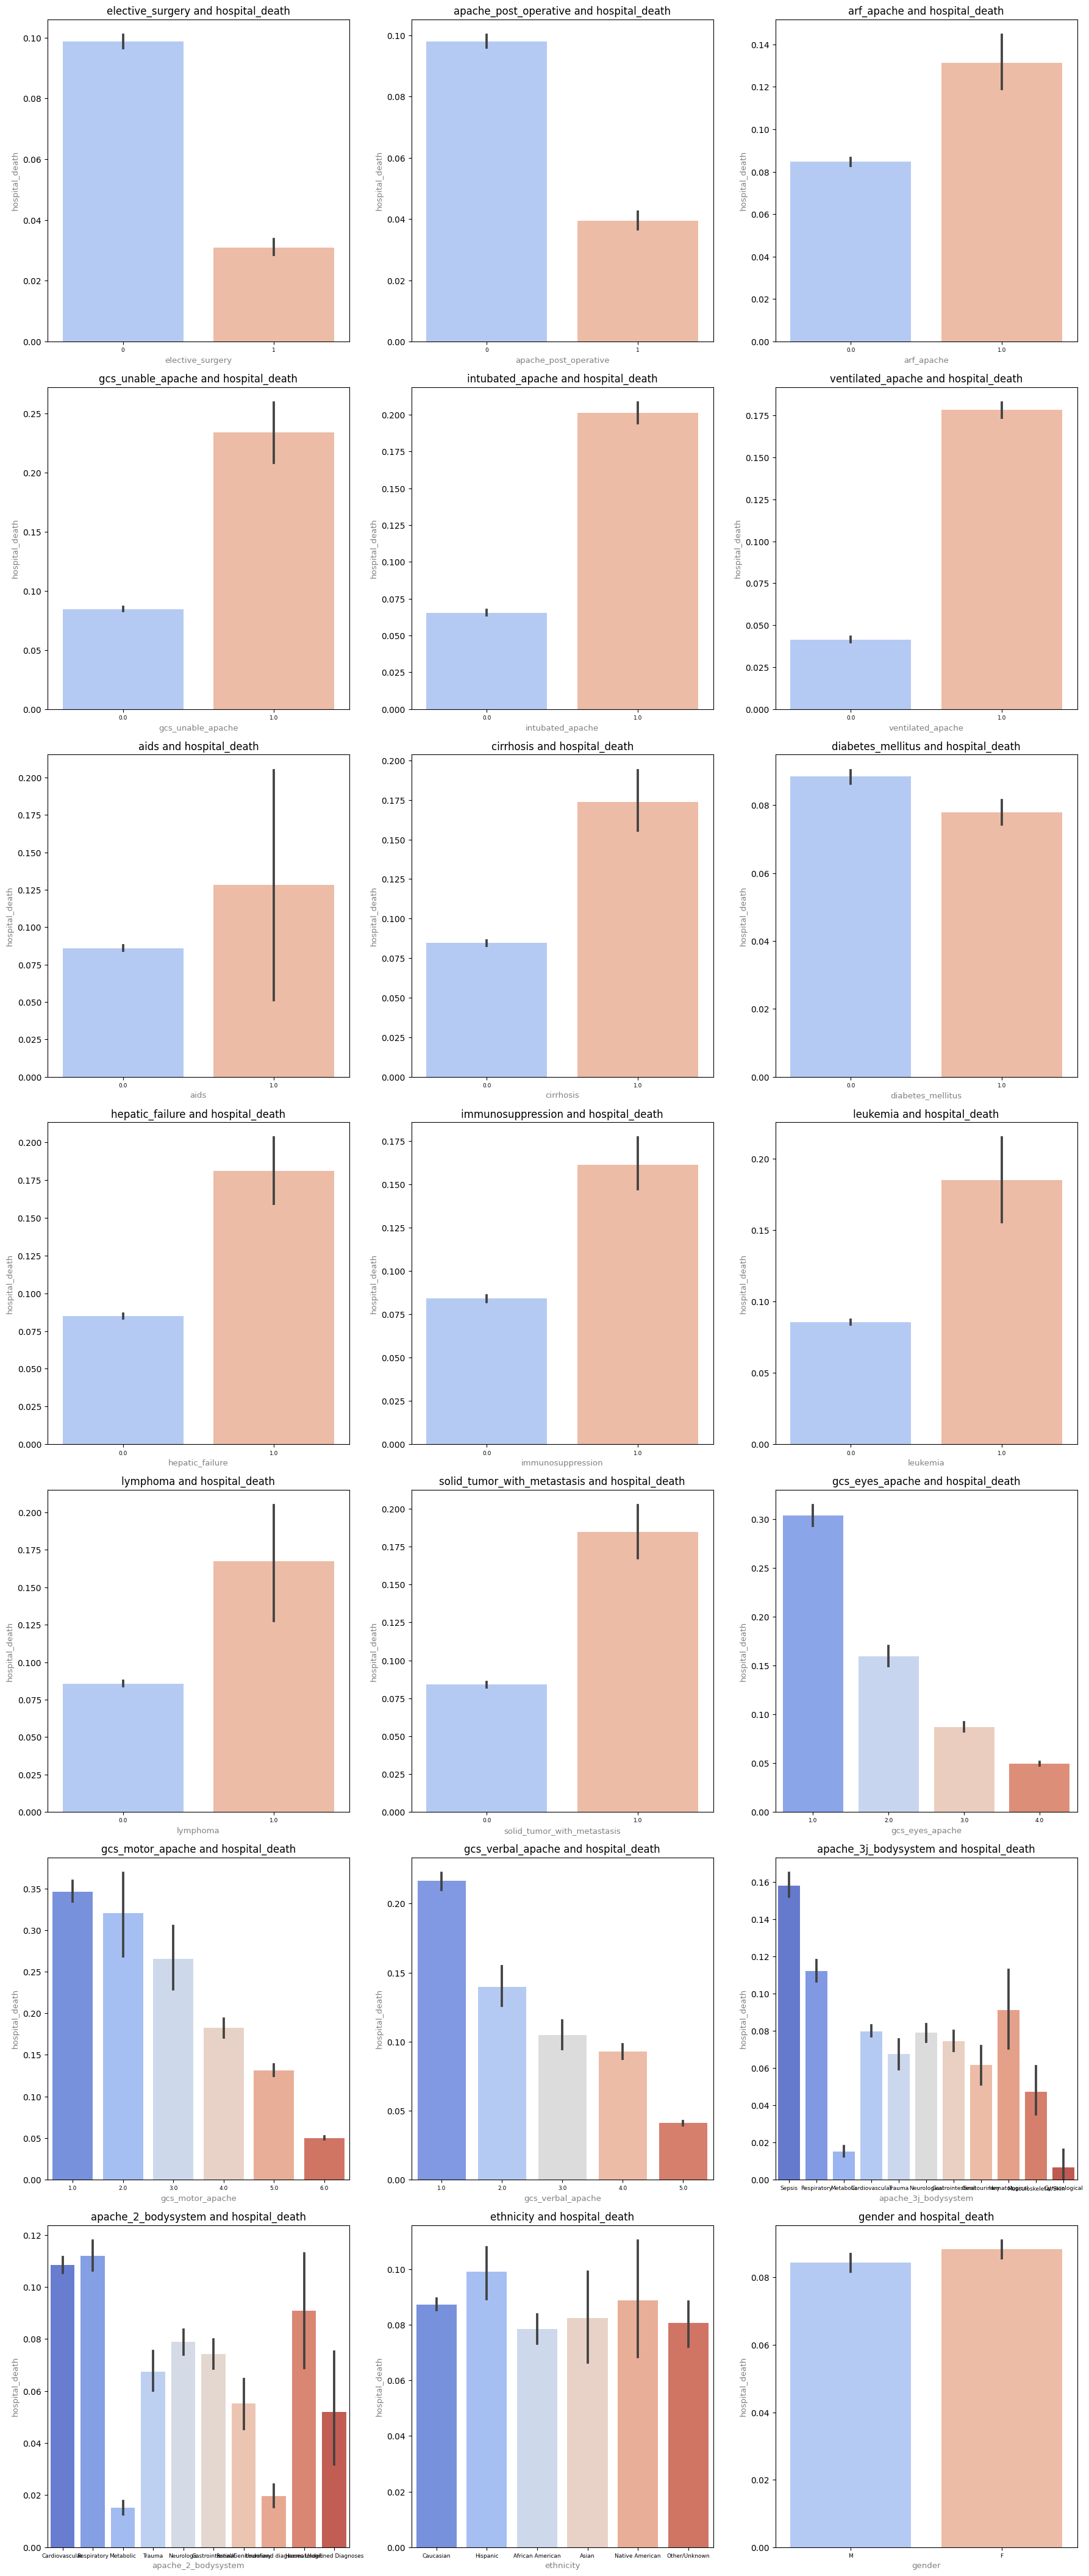

In [ ]:
# Grouping variables into binary, ordinal, and categorical
binary_ordinal_categorical = binary_variables + ordinal_variables + categorical_variables

#Setting Y/class

Class= 'hospital_death'

# Determining the number of subplots in each row
subplots_per_row = 3
total_rows = len(binary_ordinal_categorical) // subplots_per_row + 1

# Creating bar plots
fig, axes = plt.subplots(total_rows, subplots_per_row, figsize=(18, 6 * total_rows))

for i, variable_name in enumerate(binary_ordinal_categorical):
    row = i // subplots_per_row
    col = i % subplots_per_row
    sns.barplot(data=data, x=variable_name, y=Class, palette='coolwarm', ax=axes[row, col])
    axes[row, col].set_title(f"{variable_name} and {Class}")

# Adjusting the font size for unit names
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), fontsize=6.5)

# Adding and adjusting lables for both axes
for row in axes:
    for ax in row:
        ax.set_xlabel(ax.get_xlabel(), color='grey', fontsize=9.5)
        ax.set_ylabel(ax.get_ylabel(), color='grey', fontsize=9.5)

# Removing  empty subplots
for i in range(len(binary_ordinal_categorical), total_rows * subplots_per_row):
    fig.delaxes(axes[i // subplots_per_row, i % subplots_per_row])

plt.tight_layout()
plt.show()

It appears that differences in gender and ethnicity have limited significant association with the label class. Thus these two variables will be removed from analysis

In [ ]:
Deleting_categorical = ['gender', 'ethnicity']
data = data.drop(columns= Deleting_categorical)

In [ ]:
categorical_variables

['apache_3j_bodysystem', 'apache_2_bodysystem', 'ethnicity', 'gender']

In [ ]:
categorical_variables.remove('gender')
categorical_variables.remove('ethnicity')

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

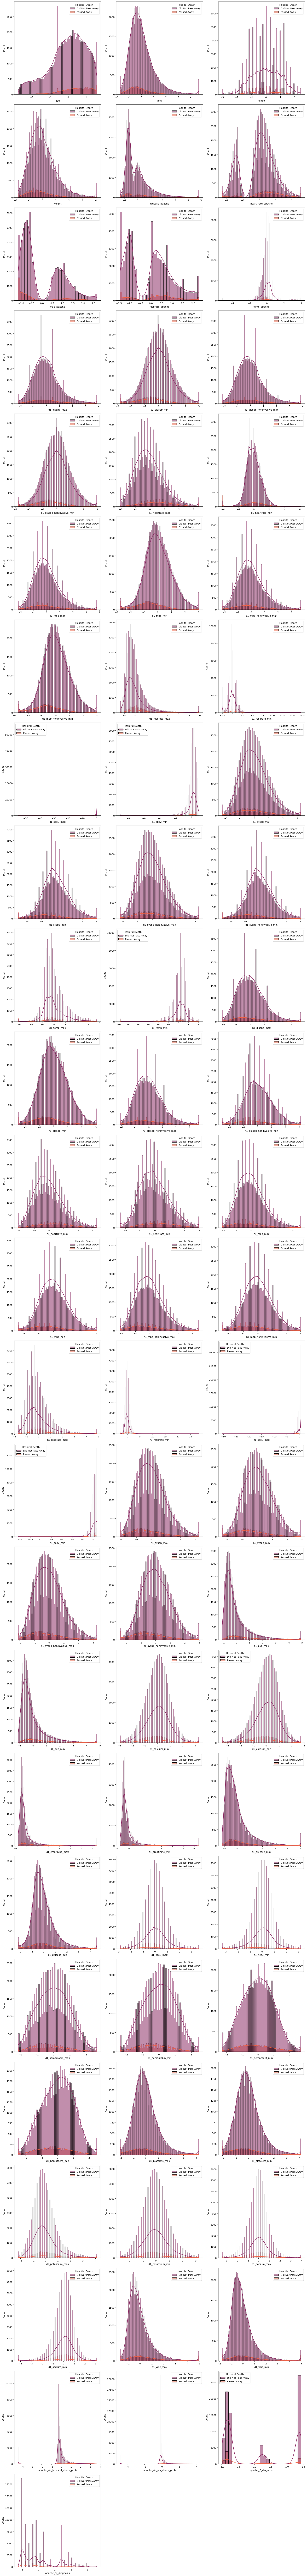

In [ ]:
# Grouping variables into numeric and integer
numeric_integer = numeric_variables + integer_variables

# Determining the number of subplots in each row
subplots_per_row = 3
total_rows = len(numeric_integer) // subplots_per_row + 1

# Creating a grid of subplots
fig, axs = plt.subplots(total_rows, subplots_per_row, figsize=(18, 6 * total_rows))

# Creating a copy of the original data
data_copy = data.copy()

# Looping through each feature in numeric_integer
for i, column in enumerate(numeric_integer):
    # Calculate the position for the subplot; x is the row index and y is the column index
    x = i // subplots_per_row
    y = i % subplots_per_row

    # Scaling the feature in the copied data using StandardScaler
    data_copy[column] = scaler.fit_transform(data_copy[[column]])

    # Plot a histogram of the scaled feature split by the 'hospital_death' class
    sns.histplot(data=data_copy, x=column, hue='Hospital Death', kde=True, palette='rocket', ax=axs[x][y])

# Removing any empty subplots
for i in range(len(numeric_integer), total_rows * subplots_per_row):
    fig.delaxes(axs[i // subplots_per_row, i % subplots_per_row])

# Display all the subplots
plt.tight_layout()
plt.show()


Histograms with Kernerl Density Estimation (KDE) were used to examine the association between the class variable and the scaled numeric/integer variables. It appears that there are many variables where the distributions of the two classes vary significantly. Yet most importantly, it appears that also many variables have extreme outliers. This is understandable as many cases that will arrive at ICU will have extreme medical conditions. As there is limited literature that guide on the standard deviations threshold for ICU patients' data, all numeric and integer variables will be included in the analysis, particularly in the RFECV.

In [ ]:
#Removing visualization variable
data.drop(columns=['Hospital Death'], inplace=True)

**2.5 Splitting data, Imputing  missing observations, and Specifying data categories**

In [ ]:
X = data.drop('hospital_death', axis=1)
y = data['hospital_death']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Data imputation is carried out after splitting data to avoid data leakage from train to test data. Univariate/Simple imputation strategies will be applied as they are straightforward and require less configuration. Yet, they are less sensitive the distribution of the data compared to iterative imputing strategy.

In [ ]:
# Creating an imputer for numeric variables with the strategy of 'mean'
numeric_imputer = SimpleImputer(strategy='mean')

# Imputing numeric variables in the training set
X_train[numeric_variables] = numeric_imputer.fit_transform(X_train[numeric_variables])

# Imputing numeric variables in the test set
X_test[numeric_variables] = numeric_imputer.transform(X_test[numeric_variables])

In [ ]:
#Creating an imputer for intefer variables with the straegy of 'median'
integer_imputer = SimpleImputer(strategy='median')

# Imputing integer variables in the training set
X_train[integer_variables] = integer_imputer.fit_transform(X_train[integer_variables])

# Imputing integer variables in the test set
X_test[integer_variables] = integer_imputer.transform(X_test[integer_variables])

In [ ]:
# Creating an imputer for categorical, ordinal, and binary variables with the strategy of 'most_frequent/mode'
category_imputer = SimpleImputer(strategy='most_frequent')

# Imputing categorical, ordinal, and binary variables in the training set
X_train[categorical_variables + ordinal_variables + binary_variables] = category_imputer.fit_transform(X_train[categorical_variables + ordinal_variables + binary_variables])

# Imputing categorical, ordinal, and binary variables in the test set
X_test[categorical_variables + ordinal_variables + binary_variables] = category_imputer.transform(X_test[categorical_variables + ordinal_variables + binary_variables])


In [ ]:
print("Numeric Variables:")
print(numeric_variables)
print("Count of Numeric Variables:", len(numeric_variables))

Numeric Variables:
['age', 'bmi', 'height', 'weight', 'glucose_apache', 'heart_rate_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_crea

In [ ]:
# Specifying data types for the training set
X_train[numeric_variables] = X_train[numeric_variables].astype(float)
X_train[integer_variables] = X_train[integer_variables].astype(int)
X_train[categorical_variables] = X_train[categorical_variables].astype('category')
X_train[binary_variables] = X_train[binary_variables].astype(int)
X_train[ordinal_variables] = X_train[ordinal_variables].astype(int)
y_train = y_train.astype(int)

# Specifying data types for the test set
X_test[numeric_variables] = X_test[numeric_variables].astype(float)
X_test[integer_variables] = X_test[integer_variables].astype(int)
X_test[categorical_variables] = X_test[categorical_variables].astype('category')
X_test[binary_variables] = X_test[binary_variables].astype(int)
X_test[ordinal_variables] = X_test[ordinal_variables].astype(int)
y_test = y_test.astype(int)


**Back to tackling imbalanced data.**

Highly imbalanced dataset (i.e., one class is predominant), might lead to the situation where a predictive model might not be able to make meaningful distinctions between the classes. As the majority class (patients who did not pass away) are significantly larger than the minority class, undersampling will be used to balance the classes. In fact, this method will be computationally efficient as it will reduce the observations in our large dataset. Yet, we might still risk losing information due to omitting observations for the majority classes.

In [ ]:
# Application of RUS for undersampling  the training data
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Specifying categorical and ordinal columns to one-hot encode
categorical_ordinal_columns = categorical_variables + ordinal_variables

# Initializing a column transformer for one-hot encoding
ct = ColumnTransformer(
    transformers=[('one_hot_encoder', OneHotEncoder(), categorical_ordinal_columns)],
    remainder='passthrough'
)

# Applying the one-hot encoding transformation to X_resampled and X_test
X_resampled = ct.fit_transform(X_resampled)
X_test = ct.transform(X_test)

In [ ]:
#converting numpyarray back to DataFrame
X_resampled = pd.DataFrame(X_resampled, columns=ct.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=ct.get_feature_names_out())

Scaling numeric variables is carried out after rus in order to ensure obtaining accurate distribution of standardized data. Later while running decision trees and random forests, we might not need scaled data. Thus, we are differentiating between both forms here.

In [ ]:
#Normalizing data
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(X_resampled.columns)

Index(['one_hot_encoder__apache_3j_bodysystem_Cardiovascular',
       'one_hot_encoder__apache_3j_bodysystem_Gastrointestinal',
       'one_hot_encoder__apache_3j_bodysystem_Genitourinary',
       'one_hot_encoder__apache_3j_bodysystem_Gynecological',
       'one_hot_encoder__apache_3j_bodysystem_Hematological',
       'one_hot_encoder__apache_3j_bodysystem_Metabolic',
       'one_hot_encoder__apache_3j_bodysystem_Musculoskeletal/Skin',
       'one_hot_encoder__apache_3j_bodysystem_Neurological',
       'one_hot_encoder__apache_3j_bodysystem_Respiratory',
       'one_hot_encoder__apache_3j_bodysystem_Sepsis',
       ...
       'remainder__apache_4a_hospital_death_prob',
       'remainder__apache_4a_icu_death_prob', 'remainder__aids',
       'remainder__cirrhosis', 'remainder__diabetes_mellitus',
       'remainder__hepatic_failure', 'remainder__immunosuppression',
       'remainder__leukemia', 'remainder__lymphoma',
       'remainder__solid_tumor_with_metastasis'],
      dtype='object',

In [ ]:
(X_resampled.shape)

(12656, 123)

In [ ]:
{X_test.shape}

{(18343, 123)}

In [ ]:
{y_test.shape}

{(18343,)}

**Section 3: Building a logistc regression model**

**3.1 Applying Recursive Feature Elimination with Cross-Validation for Logistic regession**

As this we have 124 shortlisted variables, testing all combinations might be infeasible. Thus, the recursive feature elimination with cross validation (RFECV) will be applied to find the optimal subset of variables that maximizes the performance of the model while also avoiding overfitting. The evaluation metric here will be the recall score. Removing less important variables will make the model more interpretable, and more generalizable to unseen data. The tool initiates optimization with all variables included; thereafter, it eliminates one variables at a time. The tool relies on the average performance score of the model on the test data through each iteration.

In [ ]:
#setting custom scorer
recall_scoring = make_scorer(recall_score)

In [ ]:
Log_reg_model = LogisticRegression()

cv_LR = StratifiedKFold(5)
rfecv_LR = RFECV(
    estimator=Log_reg_model,
    step=1,
    cv=cv_LR,
    scoring=recall_scoring,
    min_features_to_select=1,
)
rfecv_LR.fit(X_resampled_scaled, y_resampled)

# Print the optimal number of selected features
print(f"Optimal number of features -LR: {rfecv_LR.n_features_}")

Optimal number of features -LR: 69


In [ ]:
# which columns used and which wasn't
rfecv_LR.support_

array([ True, False,  True,  True, False,  True, False, False, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False,  True,  True,  True, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
       False,  True, False, False, False, False,  True, False,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True, False,  True, False,  True, False, False,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True, False, False, False,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True, False,
        True, False, False, False, False, False,  True])

In [ ]:
rfecv_LR.ranking_

array([ 1, 43,  1,  1, 36,  1, 29, 32,  4,  1,  1,  1, 31,  1,  1, 30,  1,
        1, 34,  1,  1,  1, 54, 21, 20,  9, 37, 39, 48,  1,  1, 53, 22, 52,
       11,  1,  1,  1,  1,  1, 56,  1,  3,  1,  1, 17,  1, 46, 33, 10, 25,
        1,  7,  1,  1,  1,  1,  1,  1, 27,  6,  1,  1,  1, 44,  1, 12,  1,
       14, 35,  1,  1, 50,  1, 23,  1,  1,  1,  1,  1, 45,  1,  1,  1,  8,
        1, 47, 24, 28,  1,  1,  1,  1,  1, 55, 51, 16, 15, 19,  2,  1, 41,
        1,  1,  1,  1,  1,  1, 38, 40,  1,  1,  1,  1,  1,  1, 42,  1, 18,
       26, 13, 49,  5,  1])

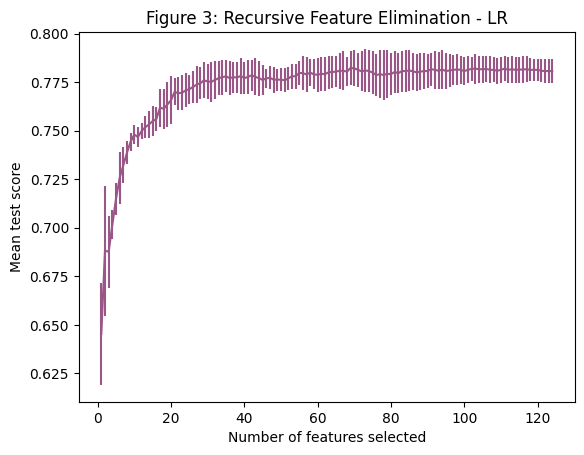

In [ ]:
# Calculate the number of different feature selections tested
n_scores_LR = len(rfecv_LR.cv_results_["mean_test_score"])

# Create a new figure for plotting
plt.figure()

# Set labels for the x and y axes
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")

# Plot the mean test scores with error bars
plt.errorbar(
    range(1, n_scores_LR + 1),
    rfecv_LR.cv_results_["mean_test_score"],
    yerr=rfecv_LR.cv_results_["std_test_score"],
    color='#995687'  # Change the color to green
)

# Set the title for the plot
plt.title("Figure 3: Recursive Feature Elimination - LR")

# Show the plot
plt.show()

In [ ]:
selected_LR_features = X_resampled.columns[rfecv_LR.support_]
eliminated_LR_features = X_resampled.columns[~rfecv_LR.support_]

print("Selected Features for LR:")
print(selected_LR_features)

print("\nEliminated Features for LR:")
print(eliminated_LR_features)

Selected Features for LR:
Index(['one_hot_encoder__apache_3j_bodysystem_Cardiovascular',
       'one_hot_encoder__apache_3j_bodysystem_Genitourinary',
       'one_hot_encoder__apache_3j_bodysystem_Gynecological',
       'one_hot_encoder__apache_3j_bodysystem_Metabolic',
       'one_hot_encoder__apache_3j_bodysystem_Sepsis',
       'one_hot_encoder__apache_3j_bodysystem_Trauma',
       'one_hot_encoder__apache_2_bodysystem_Cardiovascular',
       'one_hot_encoder__apache_2_bodysystem_Haematologic',
       'one_hot_encoder__apache_2_bodysystem_Metabolic',
       'one_hot_encoder__apache_2_bodysystem_Renal/Genitourinary',
       'one_hot_encoder__apache_2_bodysystem_Respiratory',
       'one_hot_encoder__apache_2_bodysystem_Undefined Diagnoses',
       'one_hot_encoder__apache_2_bodysystem_Undefined diagnoses',
       'one_hot_encoder__gcs_eyes_apache_1',
       'one_hot_encoder__gcs_motor_apache_5',
       'one_hot_encoder__gcs_motor_apache_6',
       'one_hot_encoder__gcs_verbal_apache_

In [ ]:
# Accessing the mean test scores
mean_test_scores_LR = rfecv_LR.cv_results_["mean_test_score"]

# Printing the list of mean test scores along with the number of selected features
for i, score_LR in enumerate(mean_test_scores_LR):
    num_selected_features = i + 1  #start with one feature
    print(f"Number of Selected Features: {num_selected_features}, Mean Test Score: {score_LR}")

Number of Selected Features: 1, Mean Test Score: 0.6453812387214406
Number of Selected Features: 2, Mean Test Score: 0.6882143503862028
Number of Selected Features: 3, Mean Test Score: 0.6875770688546291
Number of Selected Features: 4, Mean Test Score: 0.7014839930314893
Number of Selected Features: 5, Mean Test Score: 0.7147593803270704
Number of Selected Features: 6, Mean Test Score: 0.7256650993762059
Number of Selected Features: 7, Mean Test Score: 0.7321425672342631
Number of Selected Features: 8, Mean Test Score: 0.7386236567196798
Number of Selected Features: 9, Mean Test Score: 0.7443117346970634
Number of Selected Features: 10, Mean Test Score: 0.7479467246127044
Number of Selected Features: 11, Mean Test Score: 0.7466825268968272
Number of Selected Features: 12, Mean Test Score: 0.7498413352565423
Number of Selected Features: 13, Mean Test Score: 0.7517378191559111
Number of Selected Features: 14, Mean Test Score: 0.7531592454526722
Number of Selected Features: 15, Mean Test 

While the application of rfecv suggests that the optimal number of variables to inlcude in a logistic regression model is 69, the mean test score does not signifcantly increase after 24 features. Thus, lasso regression will be applied to determine important variables with non-zero coefficients. This approach is widely used in relevant research that designed prediction models for in-hospital mortality:
Zhou, Jingmin et al. (2021). Prediction model of in-hospital mortality in intensive care unit patients with heart failure: machine learning-based, retrospective analysis of the MIMIC-III database. Dryad.

**3.2 Applying Lasso Penalty to determine the important features**

In [ ]:
#creating a list for features
selected_columns_lasso = ['one_hot_encoder__apache_3j_bodysystem_Cardiovascular',
       'one_hot_encoder__apache_3j_bodysystem_Genitourinary',
       'one_hot_encoder__apache_3j_bodysystem_Gynecological',
       'one_hot_encoder__apache_3j_bodysystem_Metabolic',
       'one_hot_encoder__apache_3j_bodysystem_Sepsis',
       'one_hot_encoder__apache_3j_bodysystem_Trauma',
       'one_hot_encoder__apache_2_bodysystem_Cardiovascular',
       'one_hot_encoder__apache_2_bodysystem_Haematologic',
       'one_hot_encoder__apache_2_bodysystem_Metabolic',
       'one_hot_encoder__apache_2_bodysystem_Renal/Genitourinary',
       'one_hot_encoder__apache_2_bodysystem_Respiratory',
       'one_hot_encoder__apache_2_bodysystem_Undefined Diagnoses',
       'one_hot_encoder__apache_2_bodysystem_Undefined diagnoses',
       'one_hot_encoder__gcs_eyes_apache_1',
       'one_hot_encoder__gcs_motor_apache_5',
       'one_hot_encoder__gcs_motor_apache_6',
       'one_hot_encoder__gcs_verbal_apache_5', 'remainder__age',
       'remainder__bmi', 'remainder__elective_surgery', 'remainder__height',
       'remainder__weight', 'remainder__apache_3j_diagnosis',
       'remainder__apache_post_operative', 'remainder__gcs_unable_apache',
       'remainder__resprate_apache', 'remainder__ventilated_apache',
       'remainder__d1_diasbp_max', 'remainder__d1_diasbp_min',
       'remainder__d1_diasbp_noninvasive_max',
       'remainder__d1_diasbp_noninvasive_min', 'remainder__d1_heartrate_max',
       'remainder__d1_mbp_min', 'remainder__d1_mbp_noninvasive_max',
       'remainder__d1_mbp_noninvasive_min', 'remainder__d1_resprate_min',
       'remainder__d1_spo2_min', 'remainder__d1_sysbp_noninvasive_max',
       'remainder__d1_sysbp_noninvasive_min', 'remainder__d1_temp_min',
       'remainder__h1_diasbp_min', 'remainder__h1_diasbp_noninvasive_max',
       'remainder__h1_diasbp_noninvasive_min', 'remainder__h1_heartrate_max',
       'remainder__h1_heartrate_min', 'remainder__h1_mbp_min',
       'remainder__h1_mbp_noninvasive_max',
       'remainder__h1_mbp_noninvasive_min', 'remainder__h1_resprate_min',
       'remainder__h1_sysbp_min', 'remainder__h1_sysbp_noninvasive_max',
       'remainder__h1_sysbp_noninvasive_min', 'remainder__d1_bun_max',
       'remainder__d1_bun_min', 'remainder__d1_hco3_max',
       'remainder__d1_hemaglobin_max', 'remainder__d1_hemaglobin_min',
       'remainder__d1_hematocrit_max', 'remainder__d1_hematocrit_min',
       'remainder__d1_platelets_max', 'remainder__d1_platelets_min',
       'remainder__d1_sodium_max', 'remainder__d1_sodium_min',
       'remainder__d1_wbc_max', 'remainder__d1_wbc_min',
       'remainder__apache_4a_hospital_death_prob',
       'remainder__apache_4a_icu_death_prob', 'remainder__cirrhosis',
       'remainder__solid_tumor_with_metastasis']

In [ ]:
X_lasso = X_resampled[selected_columns_lasso]

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features in X_lasso
scaler_lasso = StandardScaler()
X_lasso_scaled = scaler_lasso.fit_transform(X_lasso)

# Create and fit the logistic regression model with Lasso regularization
logistic_regression_lasso = LogisticRegression(penalty='l1', C= 0.0027, solver='liblinear')
logistic_regression_lasso.fit(X_lasso_scaled, y_resampled)


LogisticRegression(C=0.0027, penalty='l1', solver='liblinear')

In [ ]:
# Printing the coefficients and selected feature names
coefs = logistic_regression_lasso.coef_[0]
selected_features_LR = [feature for feature, coef in zip(selected_columns_lasso, coefs) if abs(coef) != 0]
print(f"Count of variables: {len(selected_features_LR)}")
print("Variable names and their coefficients:")
for feature, coef in zip(selected_features_LR, coefs):
    print(f"{feature}: {coef}")


Count of variables: 24
Variable names and their coefficients:
one_hot_encoder__apache_3j_bodysystem_Metabolic: 0.0
one_hot_encoder__apache_2_bodysystem_Metabolic: 0.0
one_hot_encoder__apache_2_bodysystem_Undefined diagnoses: 0.0
one_hot_encoder__gcs_eyes_apache_1: -0.0001310678359641595
one_hot_encoder__gcs_motor_apache_6: 0.0
one_hot_encoder__gcs_verbal_apache_5: 0.0
remainder__age: 0.0
remainder__elective_surgery: 0.0
remainder__apache_post_operative: -0.10791600452111909
remainder__resprate_apache: 0.0
remainder__ventilated_apache: 0.0
remainder__d1_diasbp_min: 0.0
remainder__d1_heartrate_max: -0.022844040926151544
remainder__d1_mbp_min: 0.09473758124151842
remainder__d1_spo2_min: 0.0
remainder__d1_sysbp_noninvasive_min: -0.11497214132181811
remainder__d1_temp_min: -0.10264852031233827
remainder__h1_resprate_min: 0.18966476721615078
remainder__d1_bun_max: 0.0
remainder__d1_bun_min: -0.16662839857050601
remainder__d1_hco3_max: 0.0
remainder__d1_wbc_max: 0.0
remainder__apache_4a_hospi

In [ ]:
selected_features_LR

['one_hot_encoder__apache_3j_bodysystem_Metabolic',
 'one_hot_encoder__apache_2_bodysystem_Metabolic',
 'one_hot_encoder__apache_2_bodysystem_Undefined diagnoses',
 'one_hot_encoder__gcs_eyes_apache_1',
 'one_hot_encoder__gcs_motor_apache_6',
 'one_hot_encoder__gcs_verbal_apache_5',
 'remainder__age',
 'remainder__elective_surgery',
 'remainder__apache_post_operative',
 'remainder__resprate_apache',
 'remainder__ventilated_apache',
 'remainder__d1_heartrate_max',
 'remainder__d1_mbp_min',
 'remainder__d1_spo2_min',
 'remainder__d1_sysbp_noninvasive_min',
 'remainder__d1_temp_min',
 'remainder__h1_mbp_noninvasive_min',
 'remainder__h1_resprate_min',
 'remainder__d1_bun_max',
 'remainder__d1_bun_min',
 'remainder__d1_hco3_max',
 'remainder__d1_wbc_max',
 'remainder__apache_4a_hospital_death_prob',
 'remainder__solid_tumor_with_metastasis']

**3.3 Developing a logistic regression prediction model**

In [ ]:
LR_features = ['one_hot_encoder__apache_3j_bodysystem_Metabolic',
 'one_hot_encoder__apache_2_bodysystem_Metabolic',
 'one_hot_encoder__apache_2_bodysystem_Undefined diagnoses',
 'one_hot_encoder__gcs_eyes_apache_1',
 'one_hot_encoder__gcs_motor_apache_6',
 'one_hot_encoder__gcs_verbal_apache_5',
 'remainder__age',
 'remainder__elective_surgery',
 'remainder__apache_post_operative',
 'remainder__resprate_apache',
 'remainder__ventilated_apache',
 'remainder__d1_heartrate_max',
 'remainder__d1_mbp_min',
 'remainder__d1_spo2_min',
 'remainder__d1_sysbp_noninvasive_min',
 'remainder__d1_temp_min',
 'remainder__h1_mbp_noninvasive_min',
 'remainder__h1_resprate_min',
 'remainder__d1_bun_max',
 'remainder__d1_bun_min',
 'remainder__d1_hco3_max',
 'remainder__d1_wbc_max',
 'remainder__apache_4a_hospital_death_prob',
 'remainder__solid_tumor_with_metastasis']

In [ ]:
#Fitting the data
X_train_scaled_LR = scaler.fit_transform(X_resampled[LR_features])
X_test_scaled_LR = scaler.transform(X_test[LR_features])

In [ ]:
LR_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
LR_model.fit(X_train_scaled_LR, y_resampled)

LogisticRegression(solver='liblinear')

In [ ]:
# Using cross_val_predict to get predicted labels for each fold of cross-validation
predicted_labels_LR_model = cross_val_predict(LR_model, X_train_scaled_LR, y_resampled, cv=5)

# Calculating the full confusion matrix
conf_matrix_LR = confusion_matrix(y_resampled, predicted_labels_LR_model)

# Calculate the full classification report
class_report_LR = classification_report(y_resampled, predicted_labels_LR_model)

# Calculate accuracy
accuracy_LR = accuracy_score(y_resampled, predicted_labels_LR_model)

# Calculate precision
precision_LR = precision_score(y_resampled, predicted_labels_LR_model)

# Calculate recall
recall_LR = recall_score(y_resampled, predicted_labels_LR_model)

# Calculate F1 score
f1_LR = f1_score(y_resampled, predicted_labels_LR_model)


# Print the full confusion matrix and classification report
print("Table 1A: Filtered Logistic Model Confusion Matrix/Classification Report")
print("A. Confusion Matrix:")
print(conf_matrix_LR)
print("B. Classification Report:")
print(class_report_LR)
print("C. Accuracy: {:.2f}".format(accuracy_LR))
print("D. Precision: {:.2f}".format(precision_LR))
print("E. Recall (Sensitivity): {:.2f}".format(recall_LR))
print("F. F1 Score: {:.2f}".format(f1_LR))

Table 1A: Filtered Logistic Model Confusion Matrix/Classification Report
A. Confusion Matrix:
[[5058 1270]
 [1424 4904]]
B. Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      6328
           1       0.79      0.77      0.78      6328

    accuracy                           0.79     12656
   macro avg       0.79      0.79      0.79     12656
weighted avg       0.79      0.79      0.79     12656

C. Accuracy: 0.79
D. Precision: 0.79
E. Recall (Sensitivity): 0.77
F. F1 Score: 0.78


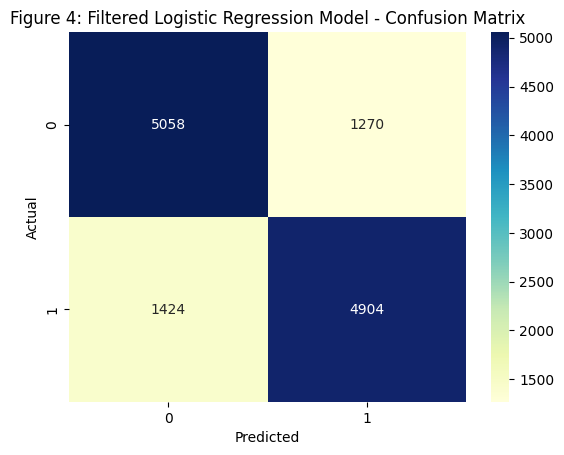

In [ ]:
sns.heatmap(conf_matrix_LR, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Figure 4: Filtered Logistic Regression Model - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

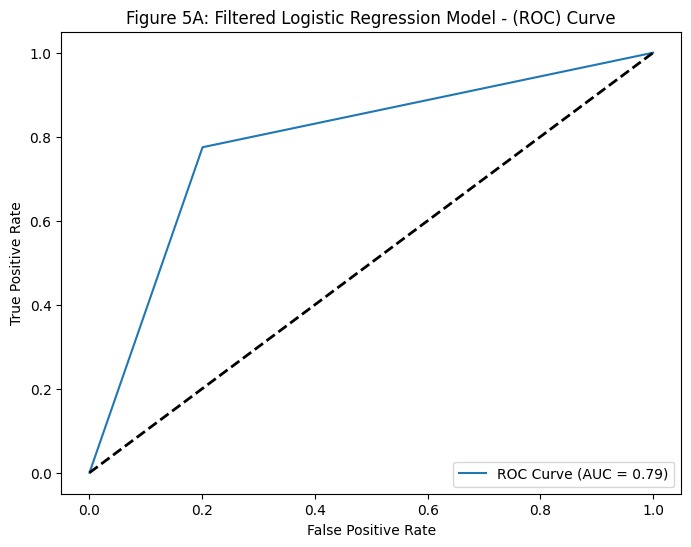

In [ ]:
predicted_probs_LR = cross_val_predict(LR_model, X_train_scaled_LR, y_resampled, cv=5)

# Calculate ROC-AUC
roc_auc_LR = roc_auc_score(y_resampled, predicted_probs_LR)

# Calculate ROC curve
fpr_LR, tpr_LR, _ = roc_curve(y_resampled, predicted_probs_LR)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_LR, tpr_LR, label=f'ROC Curve (AUC = {roc_auc_LR:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 5A: Filtered Logistic Regression Model - (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Making predictions on the test set of Logit Regression
y_pred_test_LR = LR_model.predict(X_test_scaled_LR)

# Calculating metrics
accuracy_test_LR = accuracy_score(y_test, y_pred_test_LR)
precision_test_LR = precision_score(y_test, y_pred_test_LR)
recall_test_LR = recall_score(y_test, y_pred_test_LR)
f1_test_LR = f1_score(y_test, y_pred_test_LR)
conf_matrix_test_LR = confusion_matrix(y_test, y_pred_test_LR)

# Printing the evaluation metrics
print("Table 1B: Filtered Logistic Model - Test Set- Confusion Matrix/Classification Report")
print("Accuracy: {:.2f}".format(accuracy_test_LR))
print("Precision: {:.2f}".format(precision_test_LR))
print("Recall (Sensitivity): {:.2f}".format(recall_test_LR))
print("F1 Score: {:.2f}".format(f1_test_LR))
print("Confusion Matrix:")
print(conf_matrix_test_LR)

Table 1B: Filtered Logistic Model - Test Set- Confusion Matrix/Classification Report
Accuracy: 0.79
Precision: 0.26
Recall (Sensitivity): 0.78
F1 Score: 0.39
Confusion Matrix:
[[13291  3465]
 [  349  1238]]


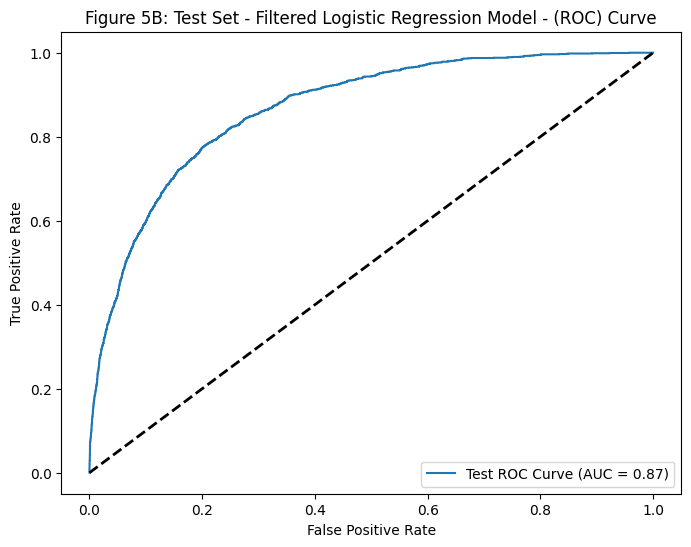

In [ ]:
# Making predictions on the test set of Logistic Regression
predicted_probs_test_LR = LR_model.predict_proba(X_test_scaled_LR)[:, 1]

# Calculate ROC-AUC on the test set
roc_auc_test_LR = roc_auc_score(y_test, predicted_probs_test_LR)

# Calculate ROC curve on the test set
fpr_test_LR, tpr_test_LR, _ = roc_curve(y_test, predicted_probs_test_LR)

# Plot ROC curve for the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_LR, tpr_test_LR, label=f'Test ROC Curve (AUC = {roc_auc_test_LR:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 5B: Test Set - Filtered Logistic Regression Model - (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

It seems that logistic regression is performing relatively well. Accuracy and recall scores on unseen (test) data is 0.79 and 0.78 respectively. AUC of the application of the model on the unseen is 0.87 which is an increase of 8 points, compared to the AUC of the application of the model on the training data. Yet, when the model was fit to the unseen data, F1 score and precision dropped significantly. Due the complex relationship between the dependent variables, decisionTrees might provide better perdictive abilities

**Section 4: Application of Decision Trees**

**4.1 Application of RFECV and RFE to obtain important features for Decision Trees**

RFECV was applied before in this excercise using the estimator of logitic regression. However, the scaled version of X_resampled was used as this is required for logistic regression. On the other hand, Decision Tress are not sensitive to he scale of variables as it makes splits based on individual variables. Thus, there is a need to repeat RFECV using Decision Trees as the estimator, and fitting the unscaled training data to it.

In [ ]:
DT_model = DecisionTreeClassifier()

cv_DT = StratifiedKFold(5)
rfecv_DT = RFECV(
    estimator=DT_model,
    step=1,
    cv=cv_DT,
    scoring=recall_scoring,
    min_features_to_select=1,
)

rfecv_DT.fit(X_resampled, y_resampled)

# Print the optimal number of selected features
print(f"Optimal number of features -DT: {rfecv_DT.n_features_}")

Optimal number of features -DT: 117


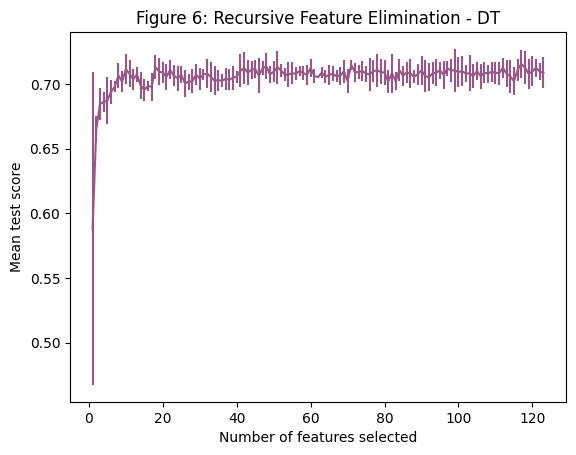

In [ ]:
# Calculate the number of different feature selections tested
n_scores_DT = len(rfecv_DT.cv_results_["mean_test_score"])

# Create a new figure for plotting
plt.figure()

# Set labels for the x and y axes
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")

# Plot the mean test scores with error bars
plt.errorbar(
    range(1, n_scores_DT + 1),
    rfecv_DT.cv_results_["mean_test_score"],
    yerr=rfecv_DT.cv_results_["std_test_score"],
    color='#995687'  # Change the color to green
)

# Set the title for the plot
plt.title("Figure 6: Recursive Feature Elimination - DT")

# Show the plot
plt.show()

In [ ]:
selected_DT_features = X_resampled.columns[rfecv_DT.support_]

print("Selected Features for DT:")
print(selected_DT_features)

Selected Features for DT:
Index(['one_hot_encoder__apache_3j_bodysystem_Genitourinary',
       'one_hot_encoder__apache_3j_bodysystem_Gynecological',
       'one_hot_encoder__apache_3j_bodysystem_Hematological',
       'one_hot_encoder__apache_3j_bodysystem_Metabolic',
       'one_hot_encoder__apache_3j_bodysystem_Musculoskeletal/Skin',
       'one_hot_encoder__apache_3j_bodysystem_Neurological',
       'one_hot_encoder__apache_3j_bodysystem_Respiratory',
       'one_hot_encoder__apache_3j_bodysystem_Sepsis',
       'one_hot_encoder__apache_3j_bodysystem_Trauma',
       'one_hot_encoder__apache_2_bodysystem_Cardiovascular',
       ...
       'remainder__d1_wbc_min', 'remainder__apache_4a_hospital_death_prob',
       'remainder__apache_4a_icu_death_prob', 'remainder__cirrhosis',
       'remainder__diabetes_mellitus', 'remainder__hepatic_failure',
       'remainder__immunosuppression', 'remainder__leukemia',
       'remainder__lymphoma', 'remainder__solid_tumor_with_metastasis'],
      d

In [ ]:
# Accessing the mean test scores
mean_test_scores_DT = rfecv_DT.cv_results_["mean_test_score"]

# Printing the list of mean test scores along with the number of selected features
for t, score_DT in enumerate(mean_test_scores_DT):
    DT_selected_features = t + 1  #start with one feature
    print(f"Number of Selected Features: {DT_selected_features}, Mean Test Score: {score_DT}")

Number of Selected Features: 1, Mean Test Score: 0.5881517836514746
Number of Selected Features: 2, Mean Test Score: 0.6649834841304035
Number of Selected Features: 3, Mean Test Score: 0.684577487215031
Number of Selected Features: 4, Mean Test Score: 0.6861583899993132
Number of Selected Features: 5, Mean Test Score: 0.6872646098320938
Number of Selected Features: 6, Mean Test Score: 0.6940576588052376
Number of Selected Features: 7, Mean Test Score: 0.6980098533240919
Number of Selected Features: 8, Mean Test Score: 0.7065434064527409
Number of Selected Features: 9, Mean Test Score: 0.7017993243791719
Number of Selected Features: 10, Mean Test Score: 0.7114418447820466
Number of Selected Features: 11, Mean Test Score: 0.7079655820517143
Number of Selected Features: 12, Mean Test Score: 0.7036998045570064
Number of Selected Features: 13, Mean Test Score: 0.7073320470312021
Number of Selected Features: 14, Mean Test Score: 0.6989555975997354
Number of Selected Features: 15, Mean Test S

While the application of rfecv here suggests that the optimal number of variables to inlcude in a Decision Trees model is 111, the mean test score does not signifcantly increase after 13 features. In this case, RFE will be used where selection of features will be set to 13. This approach would remove the least important features, based on gini impurity

In [ ]:
#setting parametres
rfe_DT = RFE(DT_model, n_features_to_select=13)
rfe_DT.fit(X_resampled, y_resampled)

#extracting features
most_important_features_DT = X_resampled.columns[rfe_DT.support_]

In [ ]:
most_important_features_DT

Index(['remainder__bmi', 'remainder__apache_3j_diagnosis',
       'remainder__d1_heartrate_max', 'remainder__d1_sysbp_min',
       'remainder__d1_sysbp_noninvasive_max', 'remainder__d1_temp_max',
       'remainder__h1_resprate_min', 'remainder__d1_creatinine_max',
       'remainder__d1_glucose_min', 'remainder__d1_platelets_min',
       'remainder__d1_wbc_min', 'remainder__apache_4a_hospital_death_prob',
       'remainder__apache_4a_icu_death_prob'],
      dtype='object')

**4.2 Hyperparametre tunning for Decision Trees**

In [ ]:
DT_features = ['remainder__bmi', 'remainder__apache_3j_diagnosis',
       'remainder__d1_heartrate_max', 'remainder__d1_sysbp_min',
       'remainder__d1_sysbp_noninvasive_max', 'remainder__d1_temp_max',
       'remainder__h1_resprate_min', 'remainder__d1_creatinine_max',
       'remainder__d1_glucose_min', 'remainder__d1_platelets_min',
       'remainder__d1_wbc_min', 'remainder__apache_4a_hospital_death_prob',
       'remainder__apache_4a_icu_death_prob']

In [ ]:
#fitting data
X_DT_train = X_resampled[DT_features]
X_DT_test = X_test[DT_features]

In [ ]:
# Initializing a Decision Tree classifier
#we already have balanced class through the previous undersampling step
#thus, class weight will be set to none instead of balanced
dt = DecisionTreeClassifier(criterion='entropy', class_weight=None)

# Creating a pipeline that applies the Decision Tree classifier
model_for_dt = Pipeline([
    ('DT', dt)
])

# Fitting the model on the training data
model_for_dt.fit(X_DT_train, y_resampled)

Pipeline(steps=[('DT', DecisionTreeClassifier(criterion='entropy'))])

In [ ]:
# Define the hyperparameter values that should be tested
param_dist_DT = {
    "DT__max_depth" : [5, 10, 15, 20 ,25, 30, 35, 40, 45,50],
    "DT__min_samples_leaf" : [5, 10, 15, 20 ,25, 30, 35, 40, 45, 55, 60, 65, 70, 75, 80],
    "DT__splitter" : ['best', 'random'],
    "DT__max_features" : ['sqrt', 'log2']
}

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Initialize Grid Search with the model and the hyperparameters to search
random_search_DT = GridSearchCV(
    model_for_dt, param_grid=param_dist_DT, cv=skf)

# Train Grid Search on the training data
random_search_DT.fit(X_DT_train, y_resampled)

# Extract results into a DataFrame
results_DT = pd.DataFrame(random_search_DT.cv_results_)

# Display the set of parameters that achieved the best score
results_DT[results_DT['rank_test_score'] == 1]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
348       0.019645      0.000759          0.00247        0.000084   

    param_DT__max_depth param_DT__max_features param_DT__min_samples_leaf  \
348                  30                   log2                         55   

    param_DT__splitter                                             params  \
348               best  {'DT__max_depth': 30, 'DT__max_features': 'log...   

     split0_test_score  split1_test_score  split2_test_score  \
348           0.771722           0.775978           0.771632   

     split3_test_score  split4_test_score  mean_test_score  std_test_score  \
348           0.767286           0.780719         0.773467         0.00455   

     rank_test_score  
348                1

In [ ]:
# Retrieve the best hyperparameters after Grid Search
random_search_DT.best_params_

{'DT__max_depth': 30,
 'DT__max_features': 'log2',
 'DT__min_samples_leaf': 55,
 'DT__splitter': 'best'}

**4.3 Developing a Decision Tree model**

In [ ]:
# Update the model's hyperparameters to the best found during Grid Search
model_for_dt = model_for_dt.set_params(**random_search_DT.best_params_)

# Refit the model using the training data
model_for_dt = model_for_dt.fit(X_DT_train, y_resampled)

In [ ]:
# Using cross_val_predict to get predicted labels for each fold of cross-validation
predicted_labels_DT_model = cross_val_predict(model_for_dt, X_DT_train, y_resampled, cv=5)

# Calculating the full confusion matrix
conf_matrix_DT = confusion_matrix(y_resampled, predicted_labels_DT_model)

# Calculate the full classification report
class_report_DT = classification_report(y_resampled, predicted_labels_DT_model)

# Calculate accuracy
accuracy_DT = accuracy_score(y_resampled, predicted_labels_DT_model)

# Calculate precision
precision_DT = precision_score(y_resampled, predicted_labels_DT_model)

# Calculate recall
recall_DT = recall_score(y_resampled, predicted_labels_DT_model)

# Calculate F1 score
f1_DT = f1_score(y_resampled, predicted_labels_DT_model)


# Print the full confusion matrix and classification report
print("Table 2A: DT Model Confusion Matrix/Classification Report")
print("A. Confusion Matrix:")
print(conf_matrix_DT)
print("B. Classification Report:")
print(class_report_DT)
print("C. Accuracy: {:.2f}".format(accuracy_DT))
print("D. Precision: {:.2f}".format(precision_DT))
print("E. Recall (Sensitivity): {:.2f}".format(recall_DT))
print("F. F1 Score: {:.2f}".format(f1_DT))

Table 2A: DT Model Confusion Matrix/Classification Report
A. Confusion Matrix:
[[4921 1407]
 [1529 4799]]
B. Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      6328
           1       0.77      0.76      0.77      6328

    accuracy                           0.77     12656
   macro avg       0.77      0.77      0.77     12656
weighted avg       0.77      0.77      0.77     12656

C. Accuracy: 0.77
D. Precision: 0.77
E. Recall (Sensitivity): 0.76
F. F1 Score: 0.77


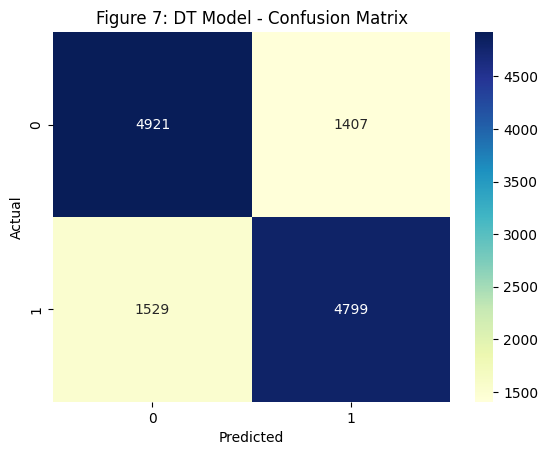

In [ ]:
sns.heatmap(conf_matrix_DT, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Figure 7: DT Model - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

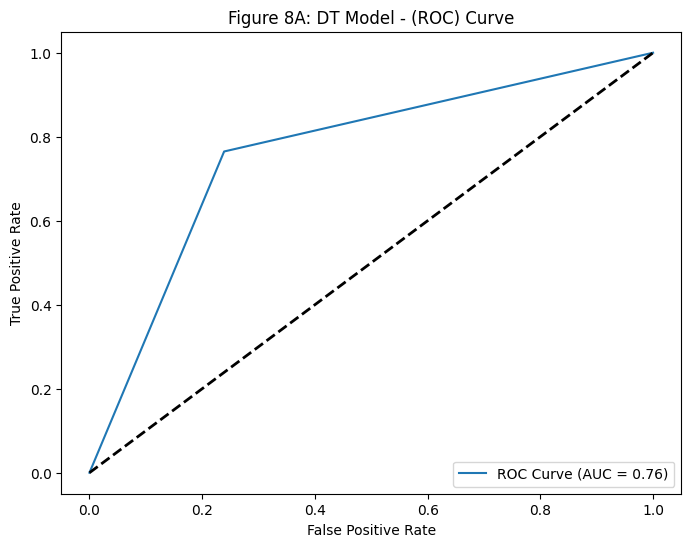

In [ ]:
predicted_probs_DT = cross_val_predict(model_for_dt, X_DT_train, y_resampled, cv=5)

# Calculate ROC-AUC
roc_auc_DT = roc_auc_score(y_resampled, predicted_probs_DT)

# Calculate ROC curve
fpr_DT, tpr_DT, _ = roc_curve(y_resampled, predicted_probs_DT)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_DT, tpr_DT, label=f'ROC Curve (AUC = {roc_auc_DT:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 8A: DT Model - (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Making predictions on the test set of the DT model
y_pred_test_DT = model_for_dt.predict(X_DT_test)

# Calculating metrics
accuracy_test_DT = accuracy_score(y_test, y_pred_test_DT)
precision_test_DT = precision_score(y_test, y_pred_test_DT)
recall_test_DT = recall_score(y_test, y_pred_test_DT)
f1_test_DT = f1_score(y_test, y_pred_test_DT)
conf_matrix_test_DT = confusion_matrix(y_test, y_pred_test_DT)

# Printing the evaluation metrics
print("Table 2B: DT Model - Test Set- Confusion Matrix/Classification Report")
print("Accuracy: {:.2f}".format(accuracy_test_DT))
print("Precision: {:.2f}".format(precision_test_DT))
print("Recall (Sensitivity): {:.2f}".format(recall_test_DT))
print("F1 Score: {:.2f}".format(f1_test_DT))
print("Confusion Matrix:")
print(conf_matrix_test_DT)

Table 2B: DT Model - Test Set- Confusion Matrix/Classification Report
Accuracy: 0.76
Precision: 0.23
Recall (Sensitivity): 0.77
F1 Score: 0.36
Confusion Matrix:
[[12743  4013]
 [  360  1227]]


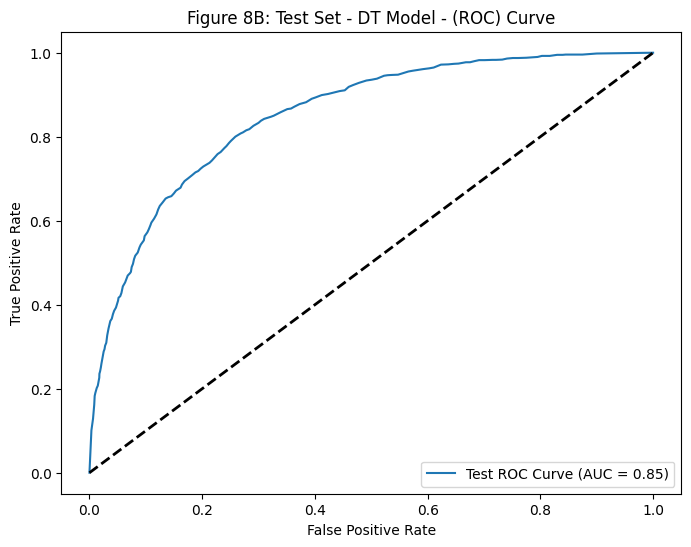

In [ ]:
# Making predictions on the test set of the DT model
predicted_probs_test_DT = model_for_dt.predict_proba(X_DT_test)[:, 1]

# Calculate ROC-AUC on the test set
roc_auc_test_DT = roc_auc_score(y_test, predicted_probs_test_DT)

# Calculate ROC curve on the test set
fpr_test_DT, tpr_test_DT, _ = roc_curve(y_test, predicted_probs_test_DT)

# Plot ROC curve for the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_DT, tpr_test_DT, label=f'Test ROC Curve (AUC = {roc_auc_test_DT:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 8B: Test Set - DT Model - (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

It seems the Decesion Tree is performing in the same capacity of Logistic Regression. Accuracy and recall scores on unseen (test) data is 0.76 and 0.77 respectively. AUC of the application of the model on the unseen is 0.85 which is an increase of nine points, compared to the AUC of the application of the model on the training data. Yet, similar to logistic regression, when the model was fit to the unseen data, F1 score and precision dropped significantly. Further application of Random Forests might provide better prediction capacities.

**Section 5: Random Forest**

**5.1 Application of RFECV and RFE to obtain important features for Random Forest**

In [ ]:
RF_model = RandomForestClassifier()

cv_RF = StratifiedKFold(5)
rfecv_RF = RFECV(
    estimator=RF_model,
    step=1,
    cv=cv_RF,
    scoring=recall_scoring,
    min_features_to_select=1,
)

rfecv_RF.fit(X_resampled, y_resampled)

# Print the optimal number of selected features
print(f"Optimal number of features -RF: {rfecv_RF.n_features_}")

Optimal number of features -RF: 111


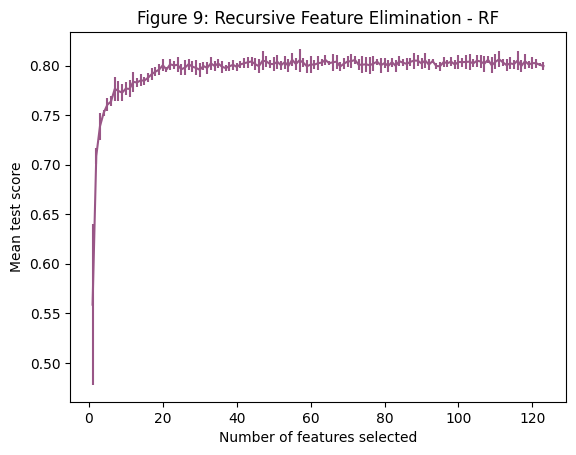

In [ ]:
# Calculate the number of different feature selections tested
n_scores_RF = len(rfecv_RF.cv_results_["mean_test_score"])

# Create a new figure for plotting
plt.figure()

# Set labels for the x and y axes
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")

# Plot the mean test scores with error bars
plt.errorbar(
    range(1, n_scores_RF + 1),
    rfecv_RF.cv_results_["mean_test_score"],
    yerr=rfecv_RF.cv_results_["std_test_score"],
    color='#995687'  # Change the color to green
)

# Set the title for the plot
plt.title("Figure 9: Recursive Feature Elimination - RF")

# Show the plot
plt.show()

In [ ]:
selected_RF_features = X_resampled.columns[rfecv_RF.support_]

print("Selected Features for RF:")
print(selected_RF_features)

Selected Features for RF:
Index(['one_hot_encoder__apache_3j_bodysystem_Cardiovascular',
       'one_hot_encoder__apache_3j_bodysystem_Gastrointestinal',
       'one_hot_encoder__apache_3j_bodysystem_Metabolic',
       'one_hot_encoder__apache_3j_bodysystem_Neurological',
       'one_hot_encoder__apache_3j_bodysystem_Respiratory',
       'one_hot_encoder__apache_3j_bodysystem_Sepsis',
       'one_hot_encoder__apache_3j_bodysystem_Trauma',
       'one_hot_encoder__apache_2_bodysystem_Cardiovascular',
       'one_hot_encoder__apache_2_bodysystem_Gastrointestinal',
       'one_hot_encoder__apache_2_bodysystem_Metabolic',
       ...
       'remainder__d1_sodium_min', 'remainder__d1_wbc_max',
       'remainder__d1_wbc_min', 'remainder__apache_4a_hospital_death_prob',
       'remainder__apache_4a_icu_death_prob', 'remainder__cirrhosis',
       'remainder__diabetes_mellitus', 'remainder__hepatic_failure',
       'remainder__immunosuppression',
       'remainder__solid_tumor_with_metastasis'],

In [ ]:
# Accessing the mean test scores
mean_test_scores_RF = rfecv_RF.cv_results_["mean_test_score"]

# Printing the list of mean test scores along with the number of selected features
for r, score_RF in enumerate(mean_test_scores_RF):
    RF_selected_features = r + 1  #start with one feature
    print(f"Number of Selected Features: {RF_selected_features}, Mean Test Score: {score_RF}")

Number of Selected Features: 1, Mean Test Score: 0.5586490081111964
Number of Selected Features: 2, Mean Test Score: 0.708752973793155
Number of Selected Features: 3, Mean Test Score: 0.7386199102086183
Number of Selected Features: 4, Mean Test Score: 0.7522120025726042
Number of Selected Features: 5, Mean Test Score: 0.7604305990046769
Number of Selected Features: 6, Mean Test Score: 0.7637472603637863
Number of Selected Features: 7, Mean Test Score: 0.7763882384529406
Number of Selected Features: 8, Mean Test Score: 0.7743334020193695
Number of Selected Features: 9, Mean Test Score: 0.772597268793436
Number of Selected Features: 10, Mean Test Score: 0.7767063172420683
Number of Selected Features: 11, Mean Test Score: 0.7763896121736632
Number of Selected Features: 12, Mean Test Score: 0.7835004901685305
Number of Selected Features: 13, Mean Test Score: 0.7828700772405697
Number of Selected Features: 14, Mean Test Score: 0.7849226657675039
Number of Selected Features: 15, Mean Test Sc



While the application of rfecv here suggests that the optimal number of variables to inlcude in a Random Forest model is 111, the mean test score does not significantly increase after 22 features. In this case, RFE will be used where selection of features will be set to 22. This approach would remove the least important features, based on gini impurity

In [ ]:
rfe_RF = RFE(RF_model, n_features_to_select=22)
rfe_RF.fit(X_resampled, y_resampled)

#extracting features
most_important_features_RF = X_resampled.columns[rfe_RF.support_]

In [ ]:
most_important_features_RF

Index(['remainder__age', 'remainder__bmi', 'remainder__weight',
       'remainder__apache_3j_diagnosis', 'remainder__ventilated_apache',
       'remainder__d1_heartrate_max', 'remainder__d1_heartrate_min',
       'remainder__d1_mbp_noninvasive_min', 'remainder__d1_resprate_max',
       'remainder__d1_spo2_min', 'remainder__d1_sysbp_max',
       'remainder__d1_sysbp_min', 'remainder__d1_sysbp_noninvasive_min',
       'remainder__d1_temp_min', 'remainder__d1_bun_max',
       'remainder__d1_bun_min', 'remainder__d1_creatinine_max',
       'remainder__d1_creatinine_min', 'remainder__d1_platelets_min',
       'remainder__d1_wbc_min', 'remainder__apache_4a_hospital_death_prob',
       'remainder__apache_4a_icu_death_prob'],
      dtype='object')

**5.2 Hyperparametre tunning for Random Forest**

In [ ]:
RF_features = ['remainder__age', 'remainder__bmi', 'remainder__weight',
       'remainder__apache_3j_diagnosis', 'remainder__ventilated_apache',
       'remainder__d1_heartrate_max', 'remainder__d1_heartrate_min',
       'remainder__d1_mbp_noninvasive_min', 'remainder__d1_resprate_max',
       'remainder__d1_spo2_min', 'remainder__d1_sysbp_max',
       'remainder__d1_sysbp_min', 'remainder__d1_sysbp_noninvasive_min',
       'remainder__d1_temp_min', 'remainder__d1_bun_max',
       'remainder__d1_bun_min', 'remainder__d1_creatinine_max',
       'remainder__d1_creatinine_min', 'remainder__d1_platelets_min',
       'remainder__d1_wbc_min', 'remainder__apache_4a_hospital_death_prob',
       'remainder__apache_4a_icu_death_prob']

In [ ]:
#fitting data
X_RF_train = X_resampled[RF_features]
X_RF_test = X_test[RF_features]

In [ ]:
# Initializing a Random Forest classifier
#we already have balanced class through the previous undersampling step
#thus, class weight will be set to none instead of balanced
rf = RandomForestClassifier(criterion='entropy', class_weight=None)

# Creating a pipeline that applies the Random Forest
model_for_rf = Pipeline([
    ('random_forest', rf)
])

# Fitting the model on the training data
model_for_rf.fit(X_RF_train, y_resampled)

Pipeline(steps=[('random_forest', RandomForestClassifier(criterion='entropy'))])

In [ ]:
# Define the hyperparameter values that should be tested
param_dist_RF = {
    "random_forest__n_estimators" : [200],
    "random_forest__max_depth" : [5, 10, 15, 20, 25, 30],
    "random_forest__min_samples_leaf" : [15, 20 ,2, 30, 35, 40],
    "random_forest__max_features" : ['sqrt']
}

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Initialize Grid Search with the model and the hyperparameters to search
random_search_RF = GridSearchCV(
    model_for_rf, param_grid=param_dist_RF, cv=skf)

# Train Grid Search on the training data
random_search_RF.fit(X_RF_train, y_resampled)

# Extract results into a DataFrame
results_RF = pd.DataFrame(random_search_RF.cv_results_)

# Display the set of parameters that achieved the best score
results_RF[results_RF['rank_test_score'] == 1]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
32       6.957941      1.034465         0.118767        0.013765   

   param_random_forest__max_depth param_random_forest__max_features  \
32                             30                              sqrt   

   param_random_forest__min_samples_leaf param_random_forest__n_estimators  \
32                                     2                               200   

                                               params  split0_test_score  \
32  {'random_forest__max_depth': 30, 'random_fores...           0.795024   

    split1_test_score  split2_test_score  split3_test_score  \
32           0.798104           0.807981           0.792967   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
32           0.809957         0.800806        0.006891                1

Hyperparameters for the Random Forest classifier are fine-tuned using Grid Search. Grid Search evaluates the model performance for each combination of the hyperparameters provided. After the search, results are saved in a DataFrame, and the row with the best-performing hyperparameters is filtered out for review.

In [ ]:
# Retrieve the best hyperparameters after Grid Search for RF
random_search_RF.best_params_

{'random_forest__max_depth': 30,
 'random_forest__max_features': 'sqrt',
 'random_forest__min_samples_leaf': 2,
 'random_forest__n_estimators': 200}

**5.3 Developing a Random Forest model**

In [ ]:
# Update the model's hyperparameters to the best found during Grid Search
model_for_rf = model_for_rf.set_params(**random_search_RF.best_params_)

# Refit the model using the training data
model_for_rf = model_for_rf.fit(X_RF_train, y_resampled)

In [ ]:
# Using cross_val_predict to get predicted labels for each fold of cross-validation
predicted_labels_RF_model = cross_val_predict(model_for_rf, X_RF_train, y_resampled, cv=5)

# Calculating the full confusion matrix
conf_matrix_RF = confusion_matrix(y_resampled, predicted_labels_RF_model)

# Calculate the full classification report
class_report_RF = classification_report(y_resampled, predicted_labels_RF_model)

# Calculate accuracy
accuracy_RF = accuracy_score(y_resampled, predicted_labels_RF_model)

# Calculate precision
precision_RF = precision_score(y_resampled, predicted_labels_RF_model)

# Calculate recall
recall_RF = recall_score(y_resampled, predicted_labels_RF_model)

# Calculate F1 score
f1_RF = f1_score(y_resampled, predicted_labels_RF_model)


# Print the full confusion matrix and classification report
print("Table 3A: RF Model Confusion Matrix/Classification Report")
print("A. Confusion Matrix:")
print(conf_matrix_RF)
print("B. Classification Report:")
print(class_report_RF)
print("C. Accuracy: {:.2f}".format(accuracy_RF))
print("D. Precision: {:.2f}".format(precision_RF))
print("E. Recall (Sensitivity): {:.2f}".format(recall_RF))
print("F. F1 Score: {:.2f}".format(f1_RF))

Table 3A: RF Model Confusion Matrix/Classification Report
A. Confusion Matrix:
[[5086 1242]
 [1277 5051]]
B. Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      6328
           1       0.80      0.80      0.80      6328

    accuracy                           0.80     12656
   macro avg       0.80      0.80      0.80     12656
weighted avg       0.80      0.80      0.80     12656

C. Accuracy: 0.80
D. Precision: 0.80
E. Recall (Sensitivity): 0.80
F. F1 Score: 0.80


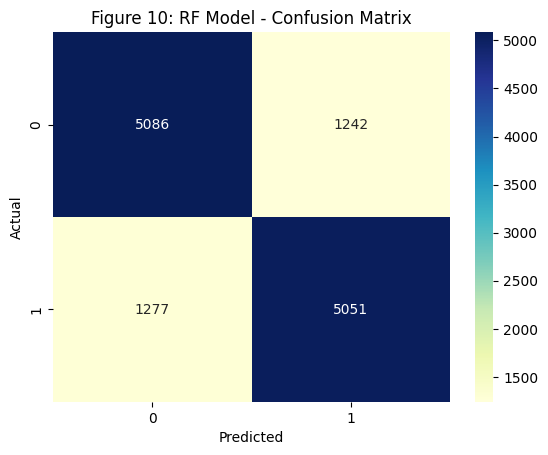

In [ ]:
sns.heatmap(conf_matrix_RF, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Figure 10: RF Model - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

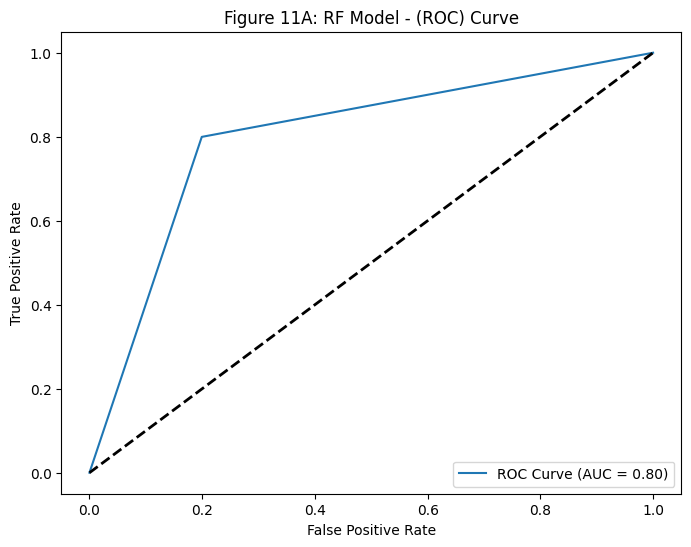

In [ ]:
predicted_probs_RF = cross_val_predict(model_for_rf, X_RF_train, y_resampled, cv=5)

# Calculate ROC-AUC
roc_auc_RF = roc_auc_score(y_resampled, predicted_probs_RF)

# Calculate ROC curve
fpr_RF, tpr_RF, _ = roc_curve(y_resampled, predicted_probs_RF)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_RF, tpr_RF, label=f'ROC Curve (AUC = {roc_auc_RF:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 11A: RF Model - (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Making predictions on the test set of the RF model
y_pred_test_RF = model_for_rf.predict(X_RF_test)

# Calculating metrics
accuracy_test_RF = accuracy_score(y_test, y_pred_test_RF)
precision_test_RF = precision_score(y_test, y_pred_test_RF)
recall_test_RF = recall_score(y_test, y_pred_test_RF)
f1_test_RF = f1_score(y_test, y_pred_test_RF)
conf_matrix_test_RF = confusion_matrix(y_test, y_pred_test_RF)

# Printing the evaluation metrics
print("Table 3B: RF Model - Test Set- Confusion Matrix/Classification Report")
print("Accuracy: {:.2f}".format(accuracy_test_RF))
print("Precision: {:.2f}".format(precision_test_RF))
print("Recall (Sensitivity): {:.2f}".format(recall_test_RF))
print("F1 Score: {:.2f}".format(f1_test_RF))
print("Confusion Matrix:")
print(conf_matrix_test_RF)

Table 3B: RF Model - Test Set- Confusion Matrix/Classification Report
Accuracy: 0.80
Precision: 0.27
Recall (Sensitivity): 0.81
F1 Score: 0.41
Confusion Matrix:
[[13345  3411]
 [  296  1291]]


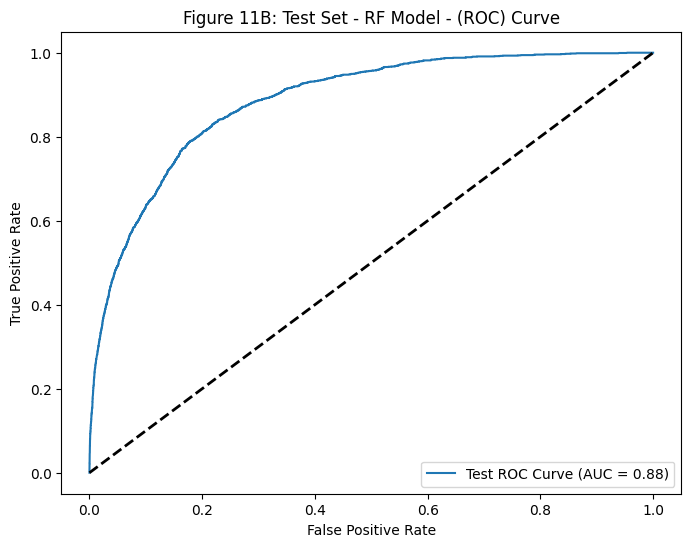

In [ ]:
# Making predictions on the test set of the RF model
predicted_probs_test_RF = model_for_rf.predict_proba(X_RF_test)[:, 1]

# Calculate ROC-AUC on the test set
roc_auc_test_RF = roc_auc_score(y_test, predicted_probs_test_RF)

# Calculate ROC curve on the test set
fpr_test_RF, tpr_test_RF, _ = roc_curve(y_test, predicted_probs_test_RF)

# Plot ROC curve for the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_RF, tpr_test_RF, label=f'Test ROC Curve (AUC = {roc_auc_test_RF:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 11B: Test Set - RF Model - (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Random Forest is performing better than Decision Tree and Logistic Regression. Accuracy and recall scores on unseen (test) data is 0.80 and 0.81 respectively. These scores are almost similar to the scores of the model when tested on the training set, which indicates that there is no overfitting in the mode. AUC of the application of the model on the unseen is 0.88 which is an increase of eight points, compared to the AUC of the application of the model on the training data. Yet, similar to logistic regression, when the model was fit to the unseen data, F1 score and precision dropped significantly. Further application of AdaBoost might provide better prediction capacities.

**Section 7: AdaBoost**

**Section 7: XGBoost**

**Section 8: Summary**

**8.1 Evaluations**

In [ ]:
# setting evaluations
evaluations = {
    'Model': ['LR Training', 'LR Test', 'DT Training', 'DT Test', 'RF Training', 'RF Test'],
    'Accuracy': [accuracy_LR, accuracy_test_LR, accuracy_DT, accuracy_test_DT, accuracy_RF, accuracy_test_RF],
    'Precision': [precision_LR, precision_test_LR, precision_DT, precision_test_DT, precision_RF, precision_test_RF],
    'Recall (Sensitivity)': [recall_LR, recall_test_LR, recall_DT, recall_test_DT, recall_RF, recall_test_RF],
    'F1 Score': [f1_LR, f1_test_LR, f1_DT, f1_test_DT, f1_RF, f1_test_RF]
}

# Creating a DataFrame
results_summary = pd.DataFrame(evaluations)

# Displaying the combined evaluation results
print(results_summary)

         Model  Accuracy  Precision  Recall (Sensitivity)  F1 Score
0  LR Training  0.787137   0.794299              0.774968  0.784514
1      LR Test  0.792073   0.263236              0.780088  0.393641
2  DT Training  0.765250   0.761816              0.771808  0.766779
3      DT Test  0.758982   0.232843              0.778198  0.358439
4  RF Training  0.800964   0.802638              0.798198  0.800412
5      RF Test  0.797907   0.274564              0.813485  0.410558


**8.2 ROC curves**

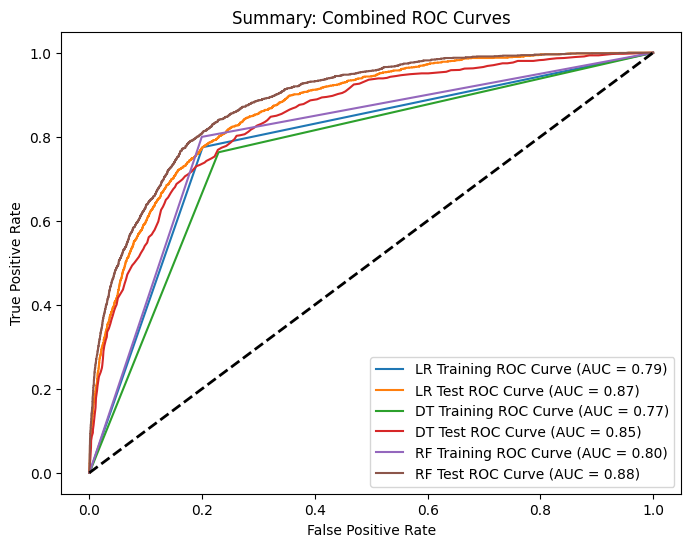

In [ ]:
# Creating a figure
plt.figure(figsize=(8, 6))

# Plotting the ROC curves for LR training and test sets
plt.plot(fpr_LR, tpr_LR, label=f'LR Training ROC Curve (AUC = {roc_auc_LR:.2f})')
plt.plot(fpr_test_LR, tpr_test_LR, label=f'LR Test ROC Curve (AUC = {roc_auc_test_LR:.2f})')

# Plotting the ROC curves for DT training and test sets
plt.plot(fpr_DT, tpr_DT, label=f'DT Training ROC Curve (AUC = {roc_auc_DT:.2f})')
plt.plot(fpr_test_DT, tpr_test_DT, label=f'DT Test ROC Curve (AUC = {roc_auc_test_DT:.2f})')

# Plotting the ROC curves for RF training and test sets
plt.plot(fpr_RF, tpr_RF, label=f'RF Training ROC Curve (AUC = {roc_auc_RF:.2f})')
plt.plot(fpr_test_RF, tpr_test_RF, label=f'RF Test ROC Curve (AUC = {roc_auc_test_RF:.2f})')

# Plotting the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Adding labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Summary: Combined ROC Curves')
plt.legend(loc='lower right')

# Display the graph
plt.show()
